In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [199]:
def rf_best_features(df, x_cols, n_features, true_col='closed_on_google'):
    
    x_columns = df[x_cols]

    y_true = df[true_col]

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features

def plot_roc(model, x_columns, y_true, title="model type"):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    if title == "model type":
        model_name = str(type(model)).split('.')[-1].strip(">\'")
    else:
        model_name = title
        
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(f'../plots/{model_name} ROC')
    plt.close()
    
def get_best_features(model, x_cols, n_features):
    
    feature_importances = {}
    
    for i in range(len(model.feature_importances_)):
        
        feature_importances[x_cols[i]] = model.feature_importances_[i]
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, name, n_features=10, figsize_x=10, figsize_y=10):
    
    values = values[:n_features]
    
    features = features[:n_features]
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    plot = new_df.plot.barh(figsize=(figsize_x,figsize_y), fontsize=100, title=name)
    plot.title.set_size(100)
    fig = plot.get_figure()
    
    fig.savefig(f'../plots/{name}')
    

Dataframe read from local .json
Column groups created
Fitting, testing, and creating/saving figs for 4 classifiers...
Plotting best features within each column group...


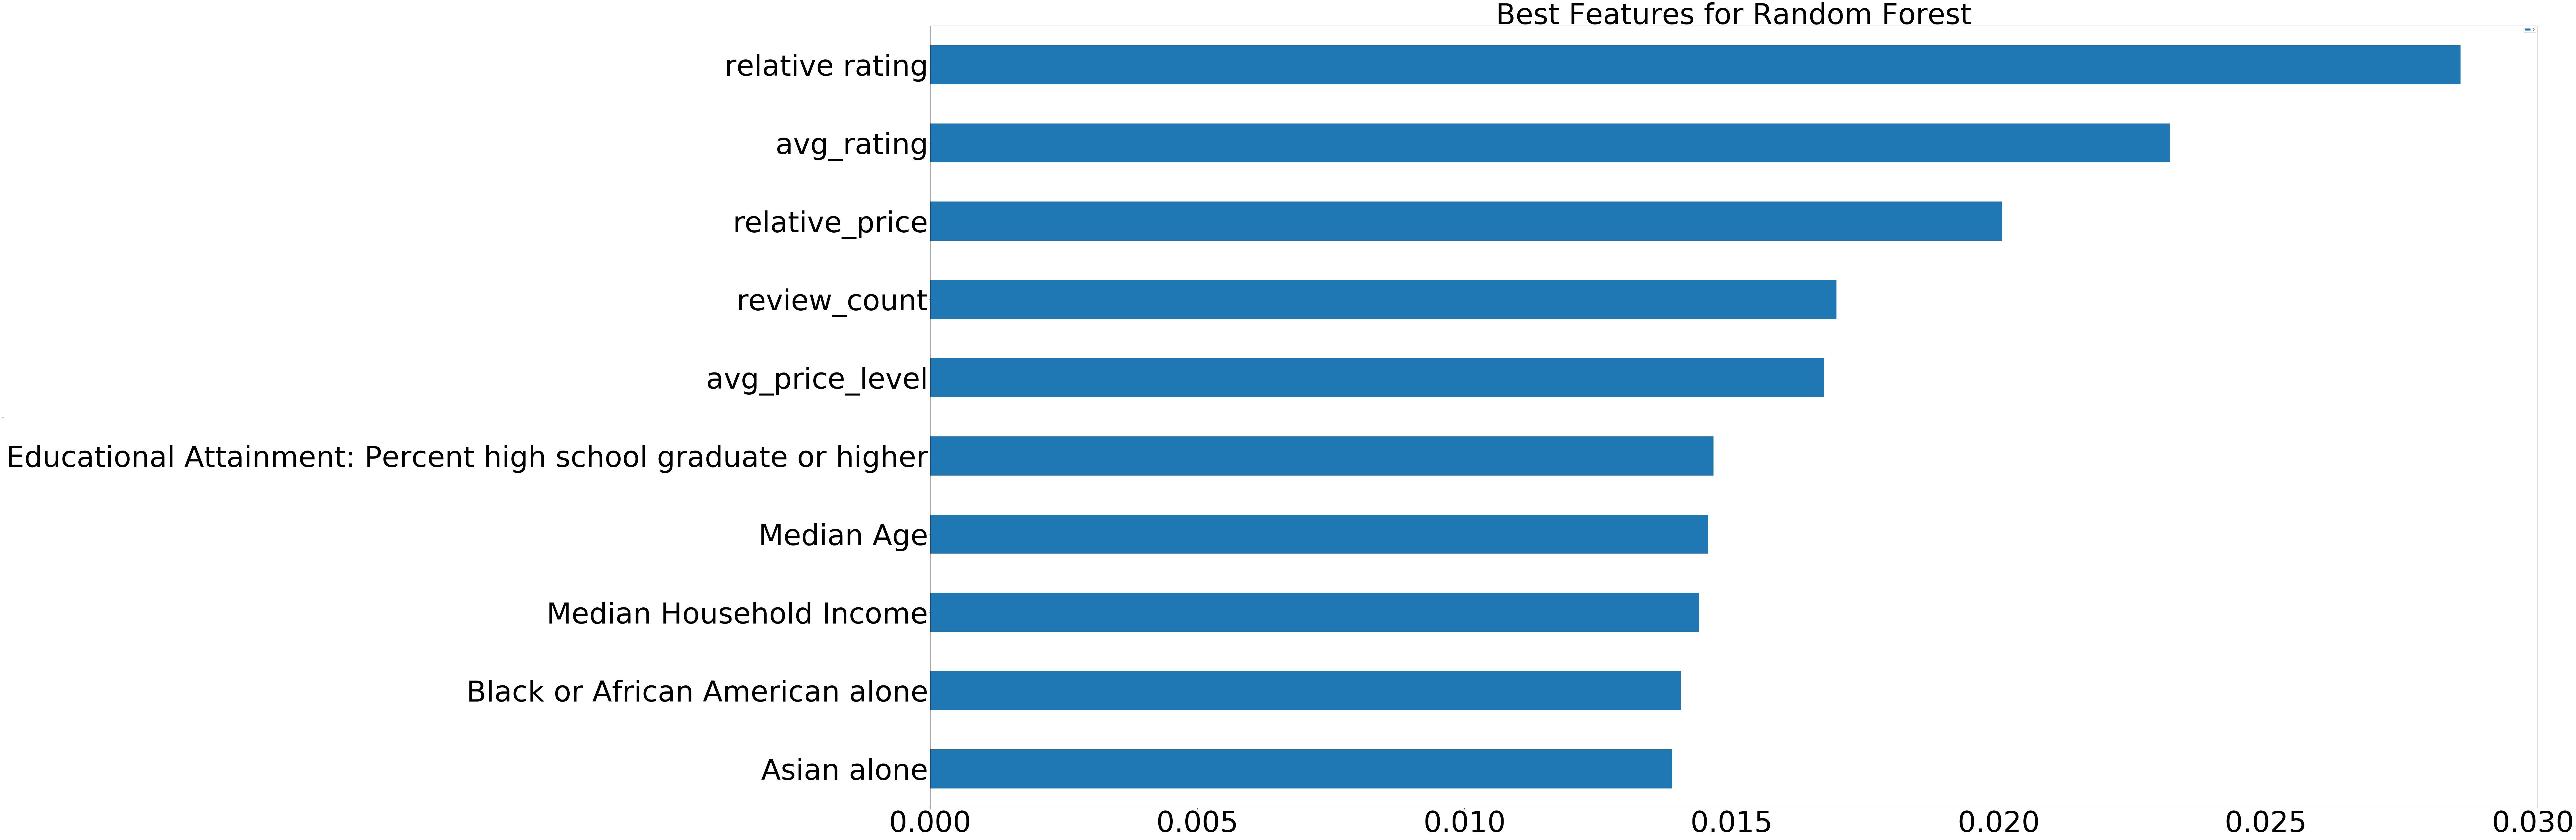

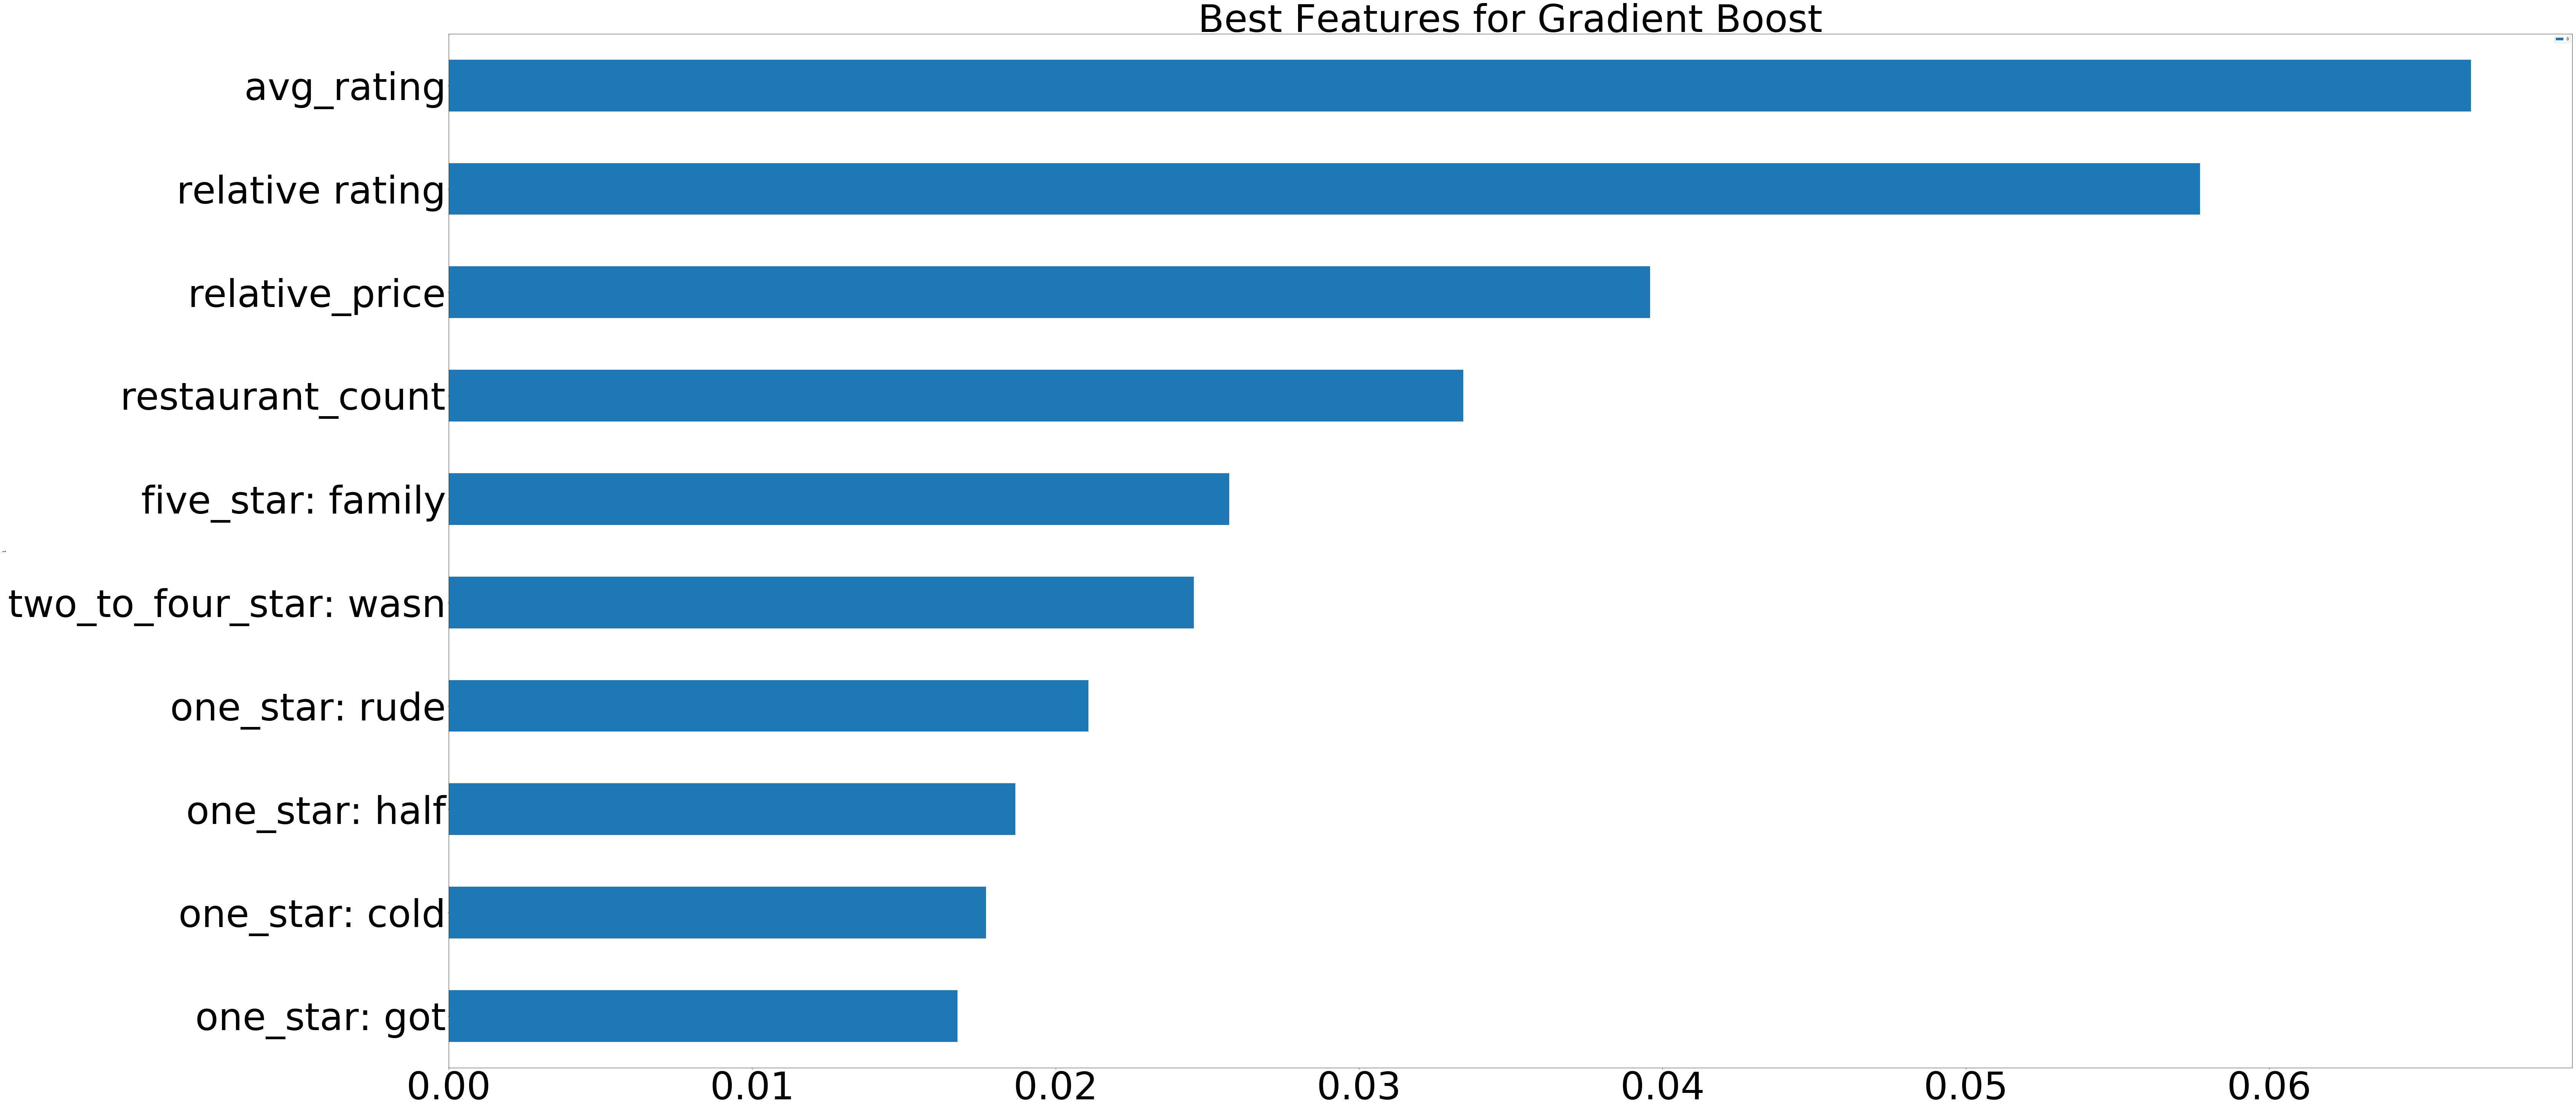

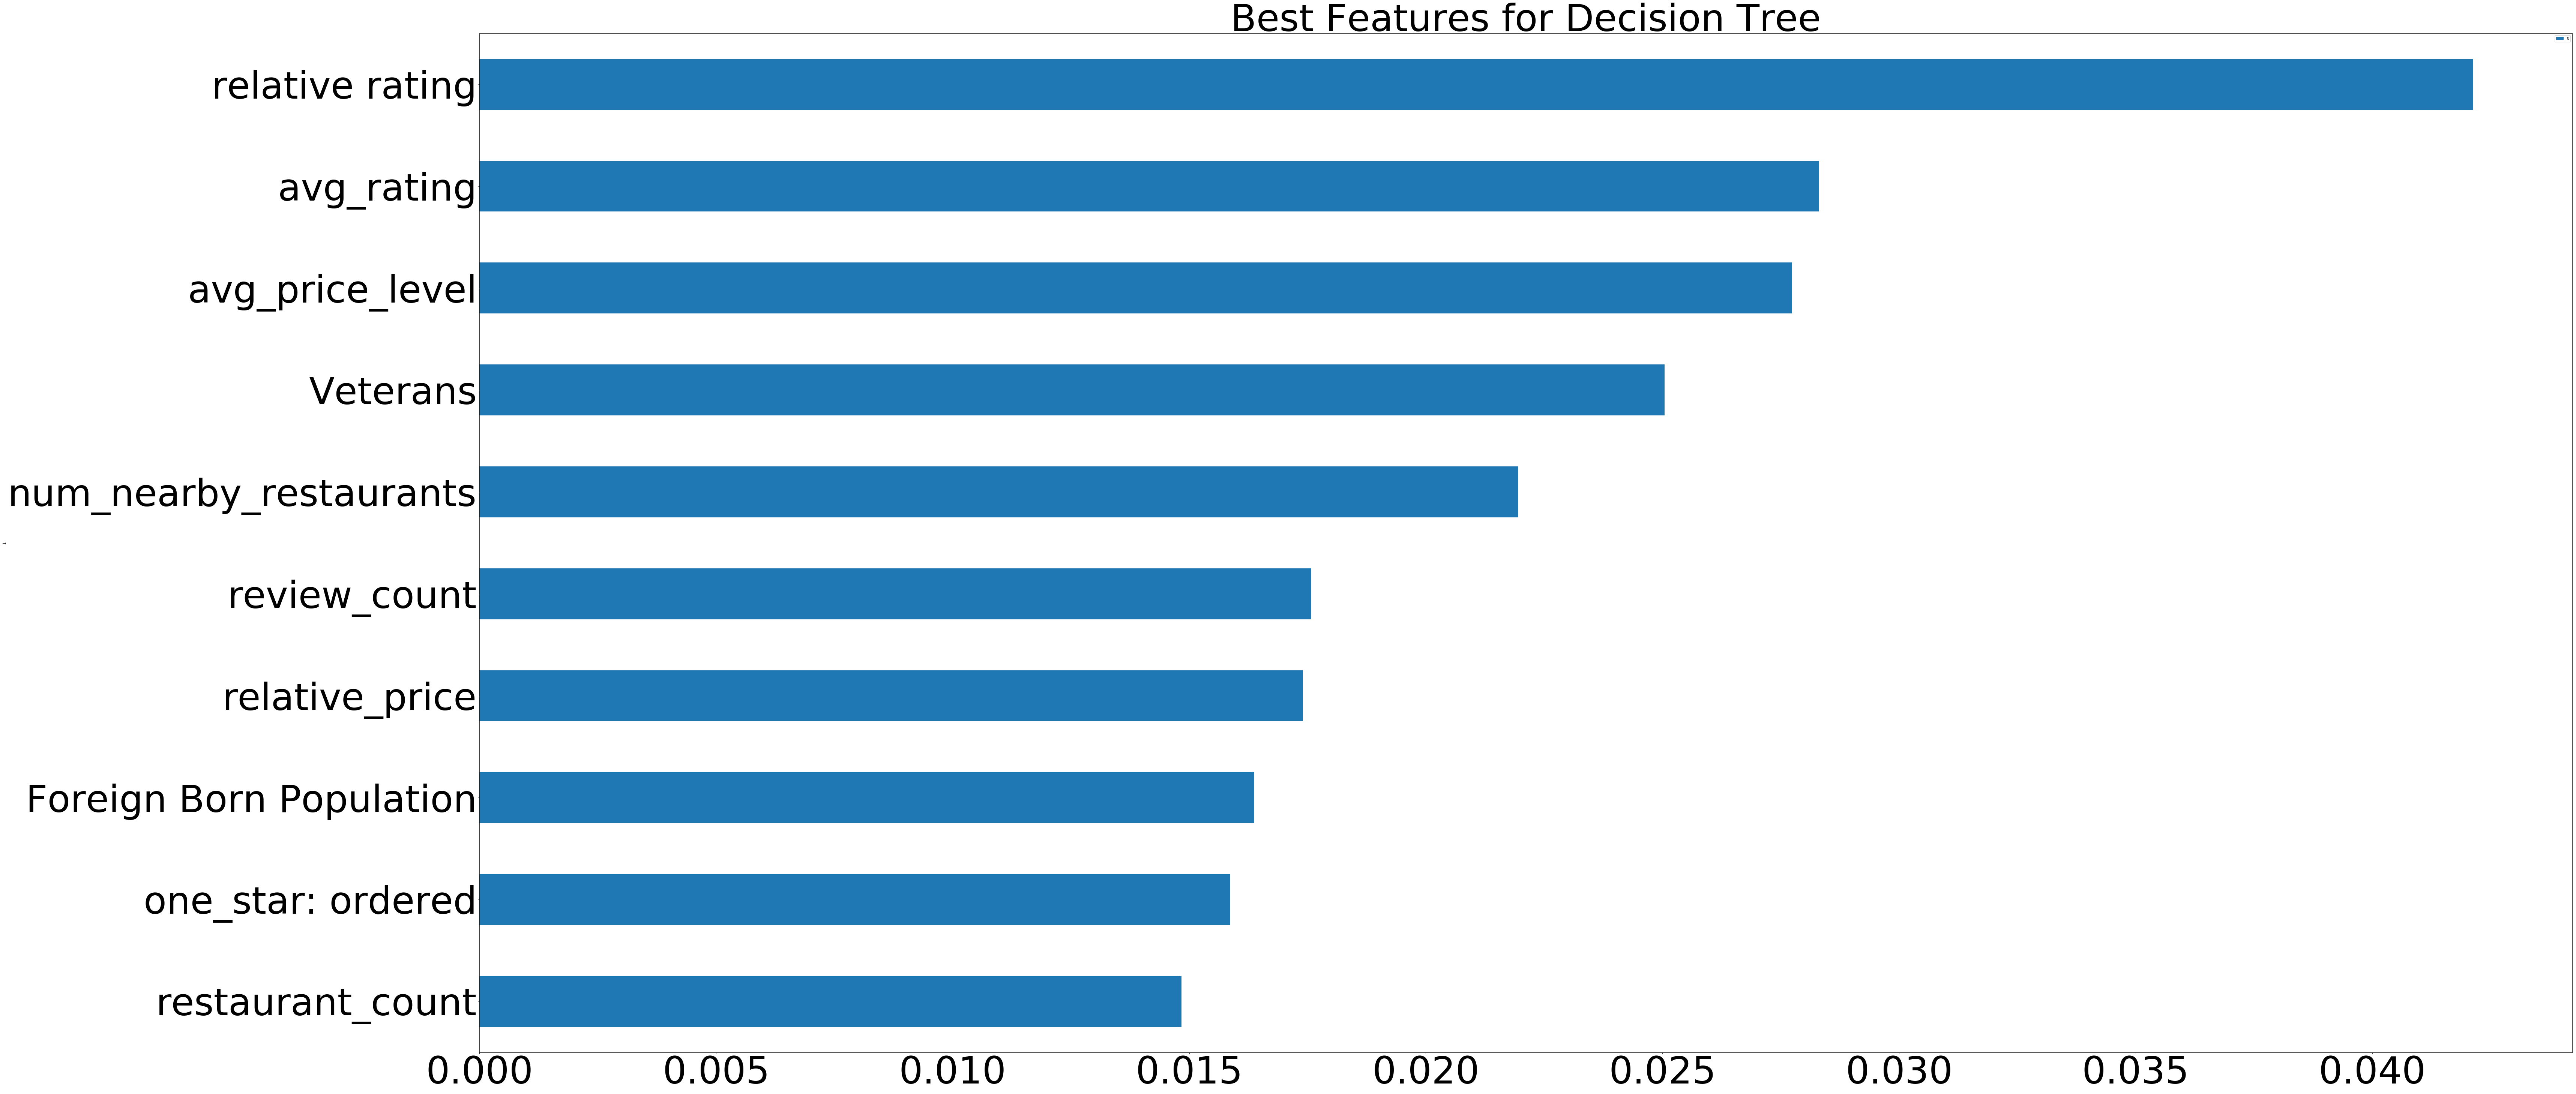

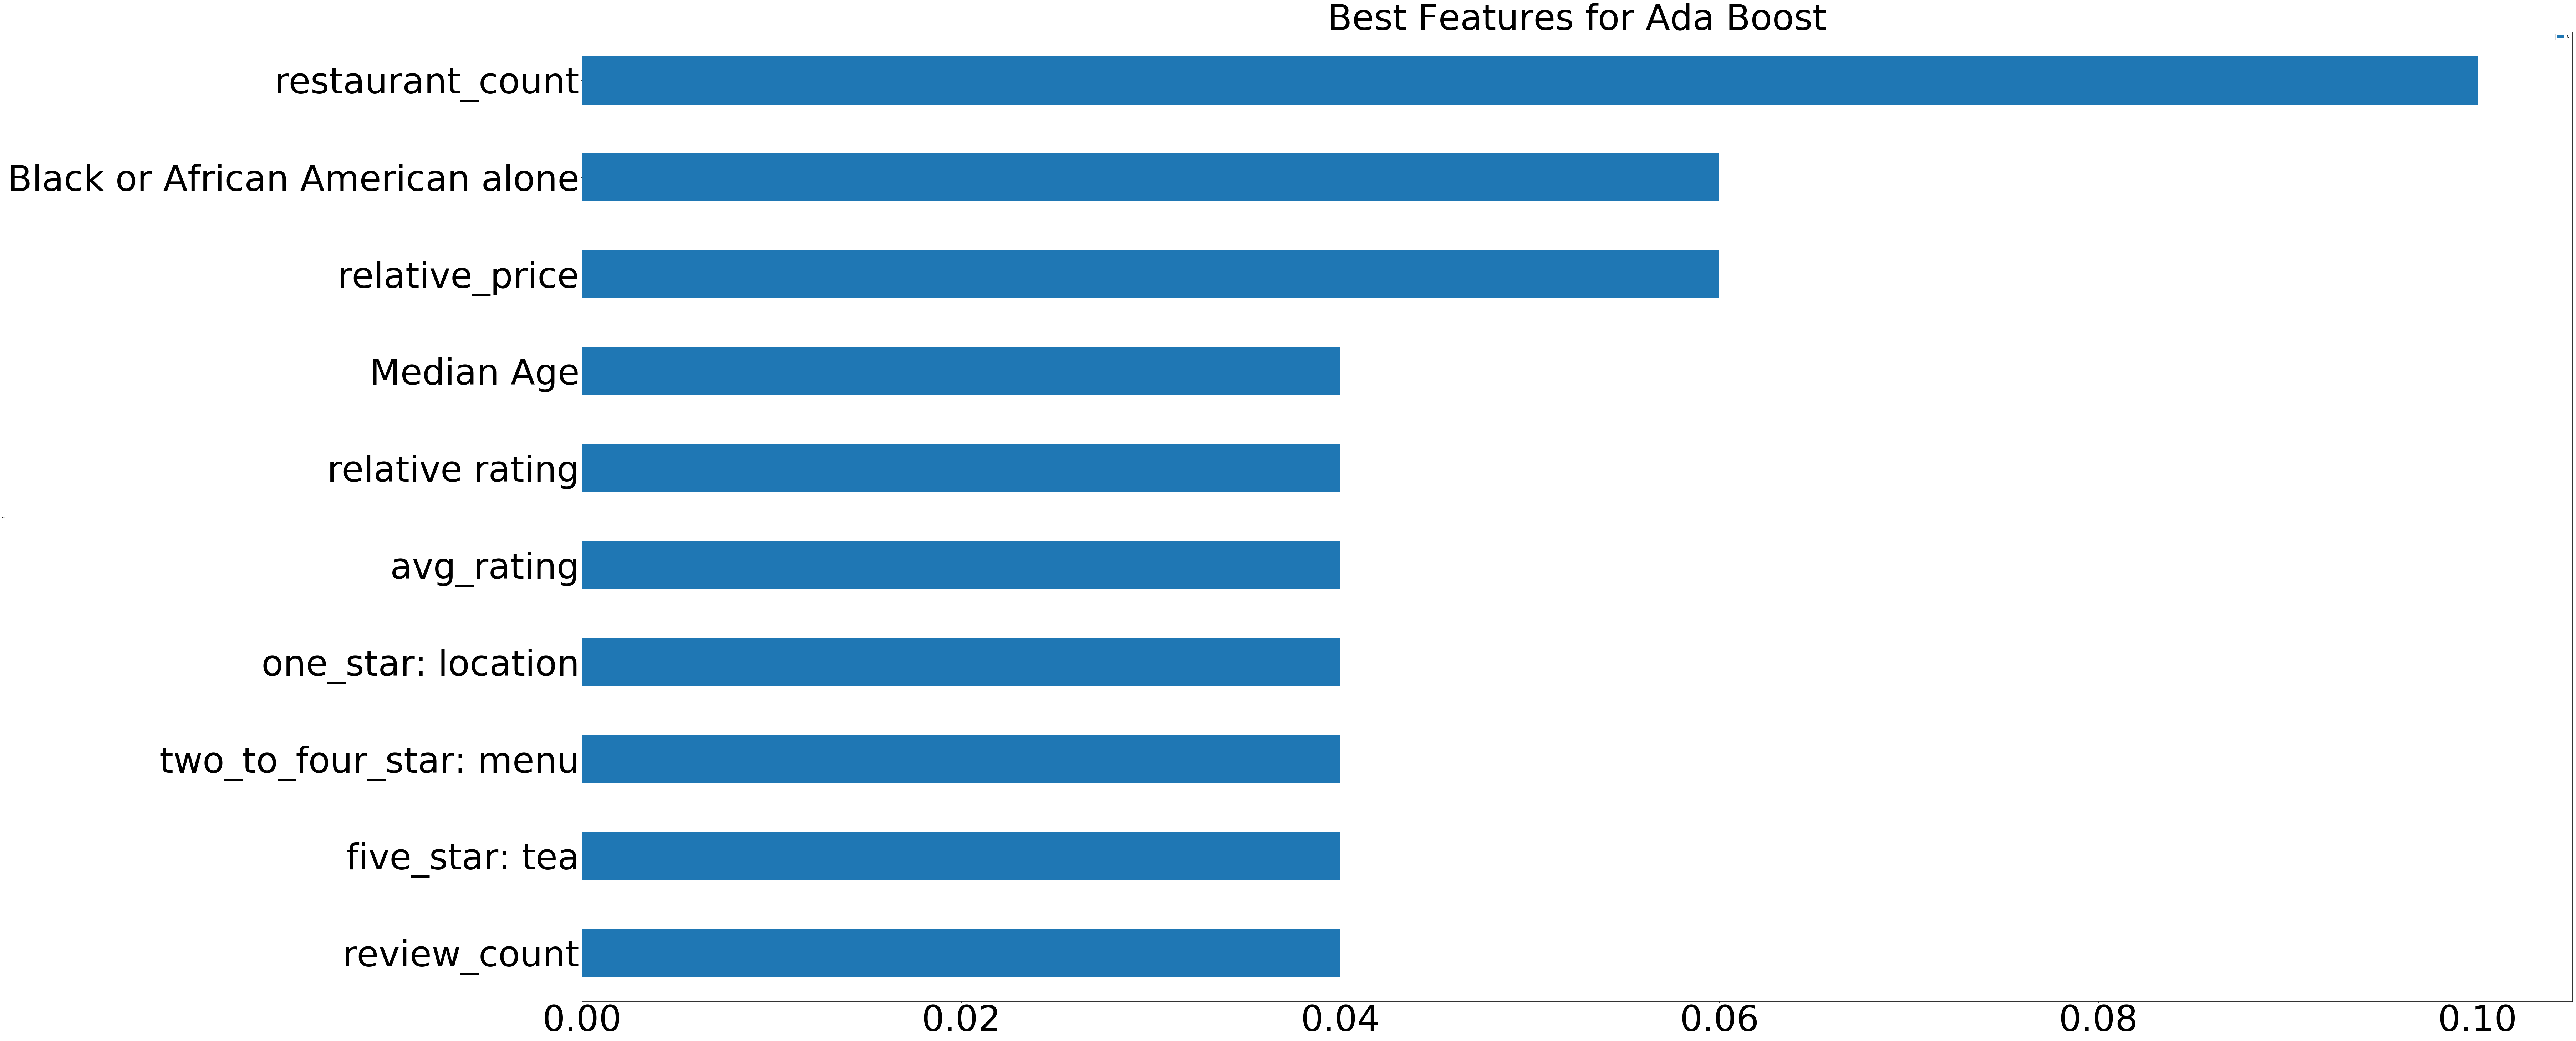

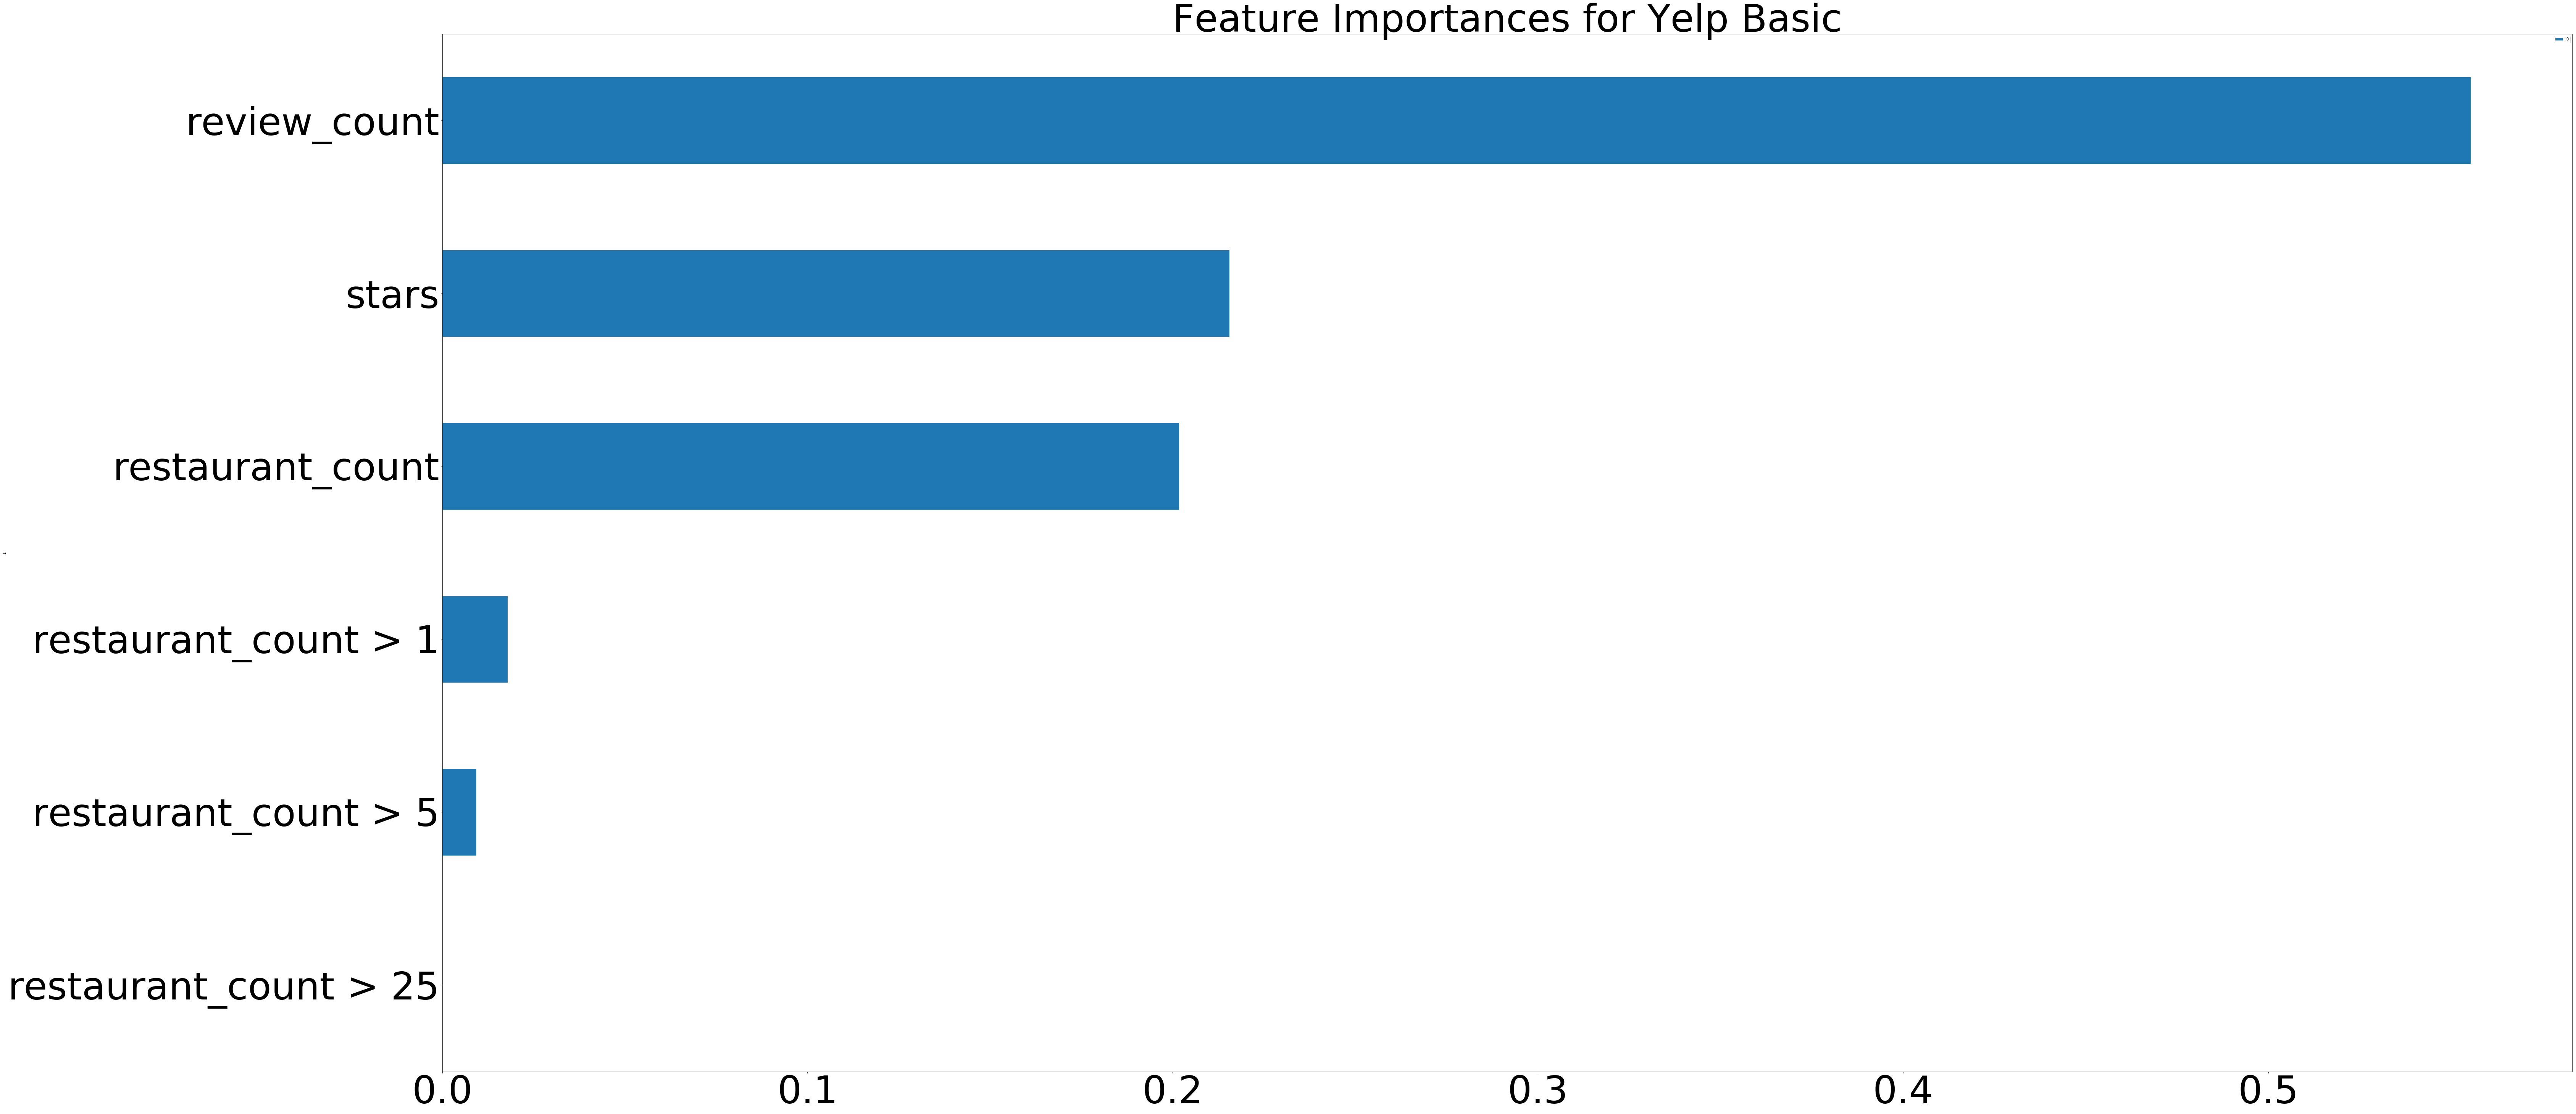

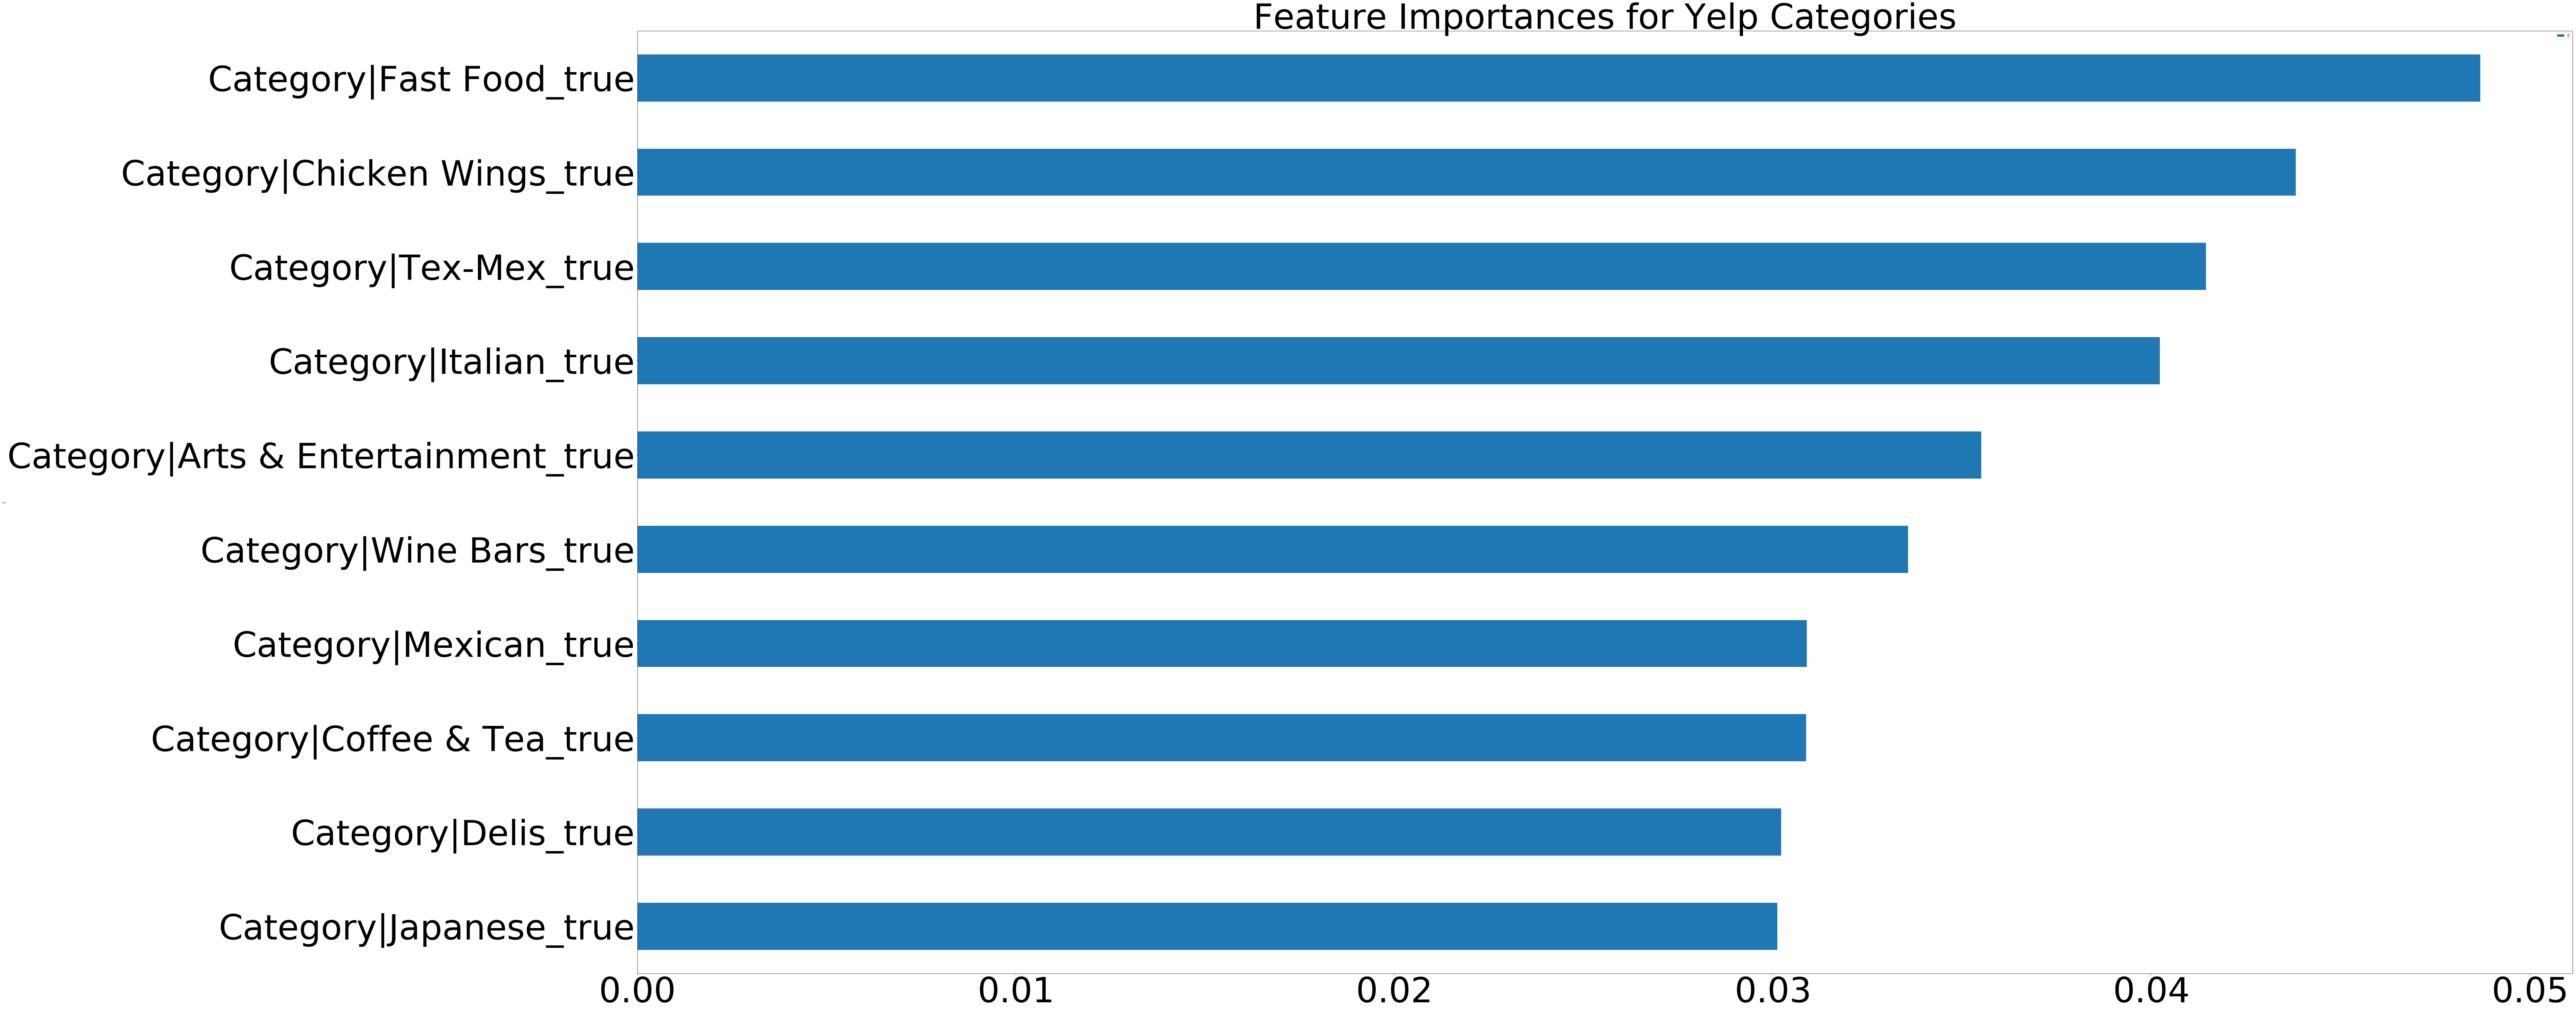

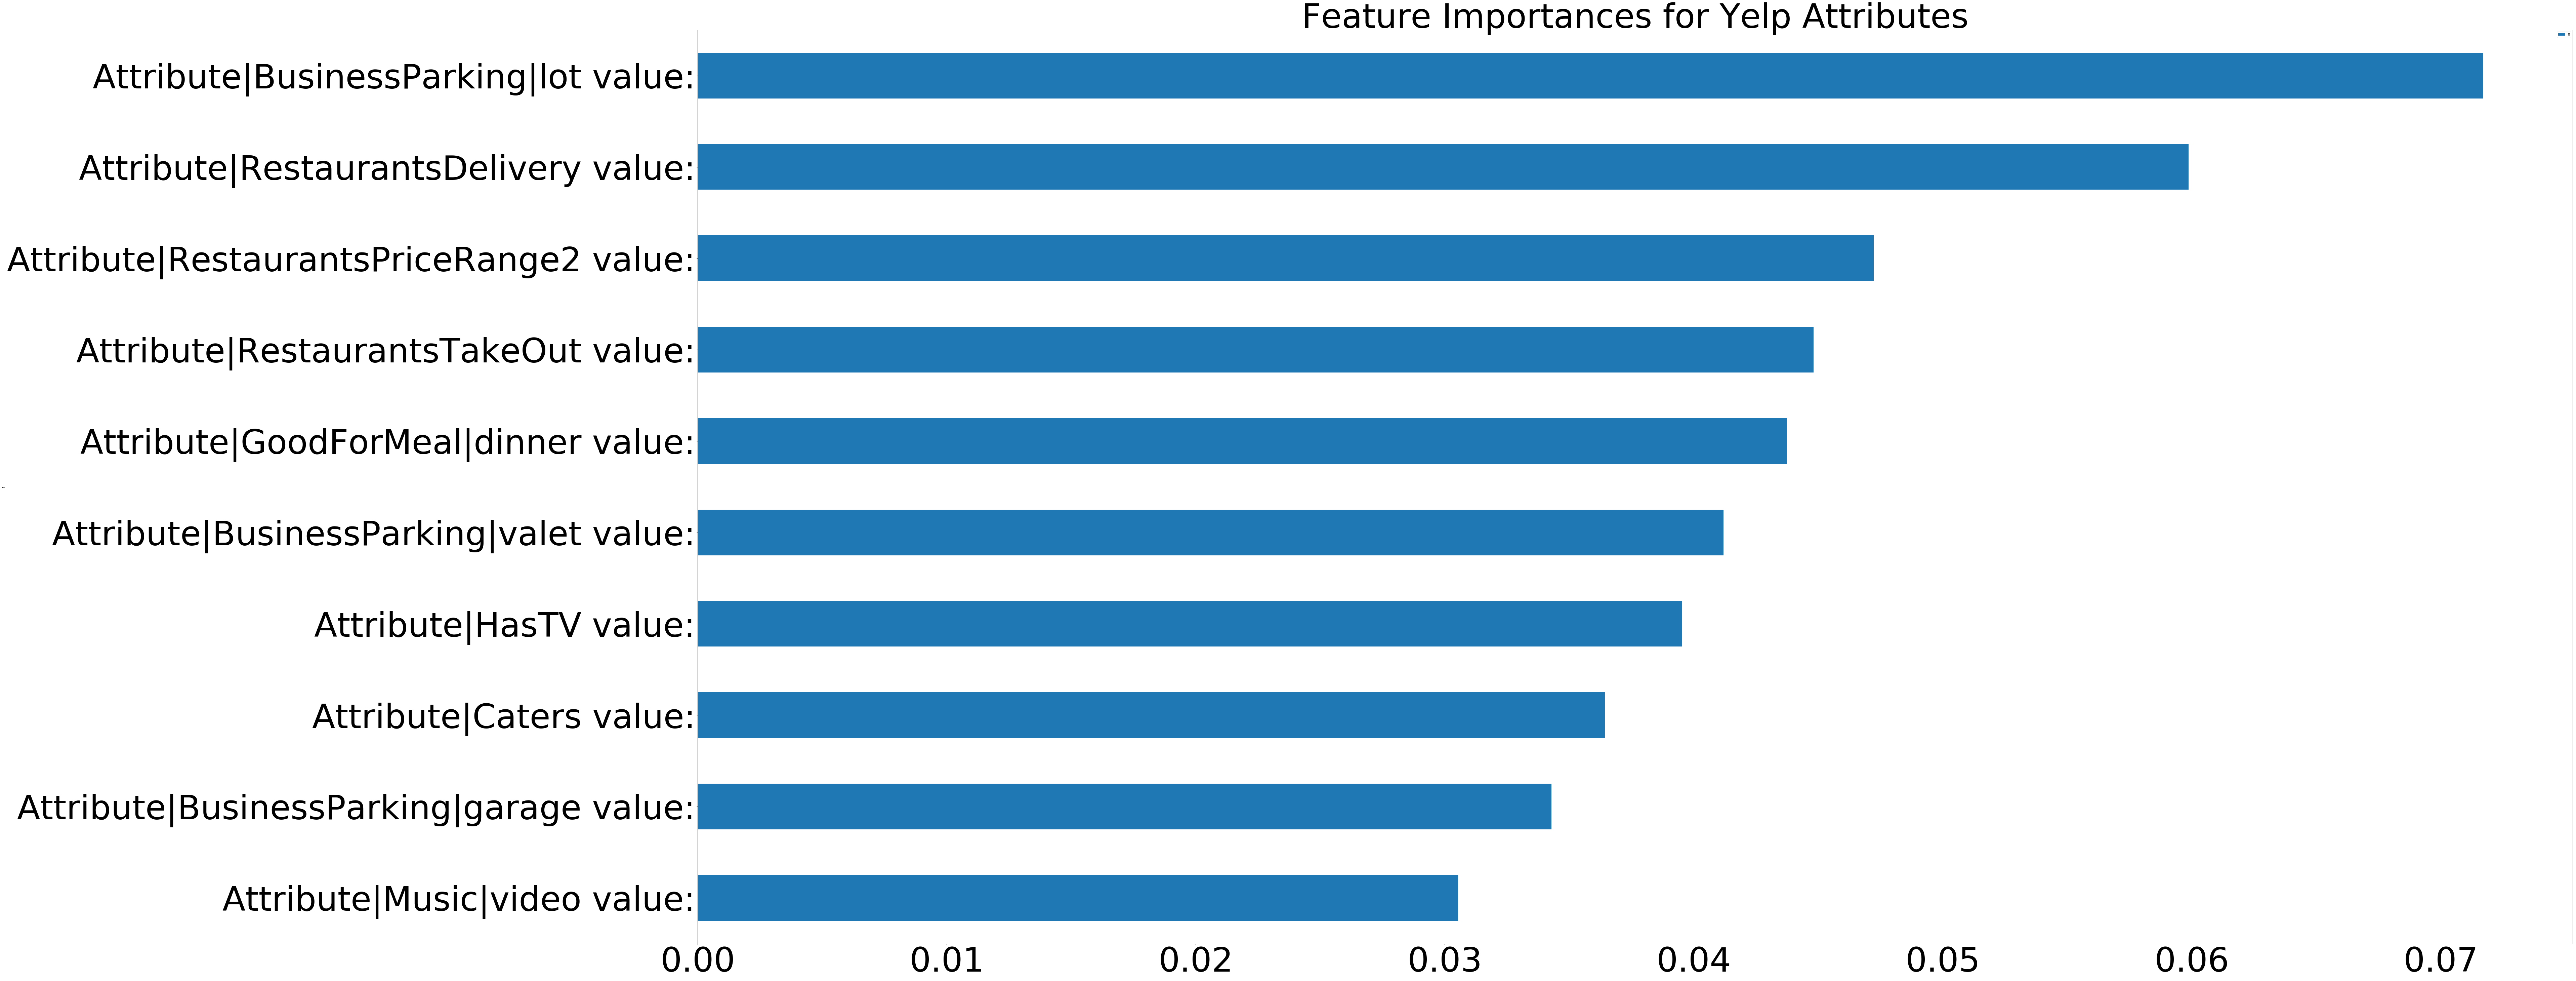

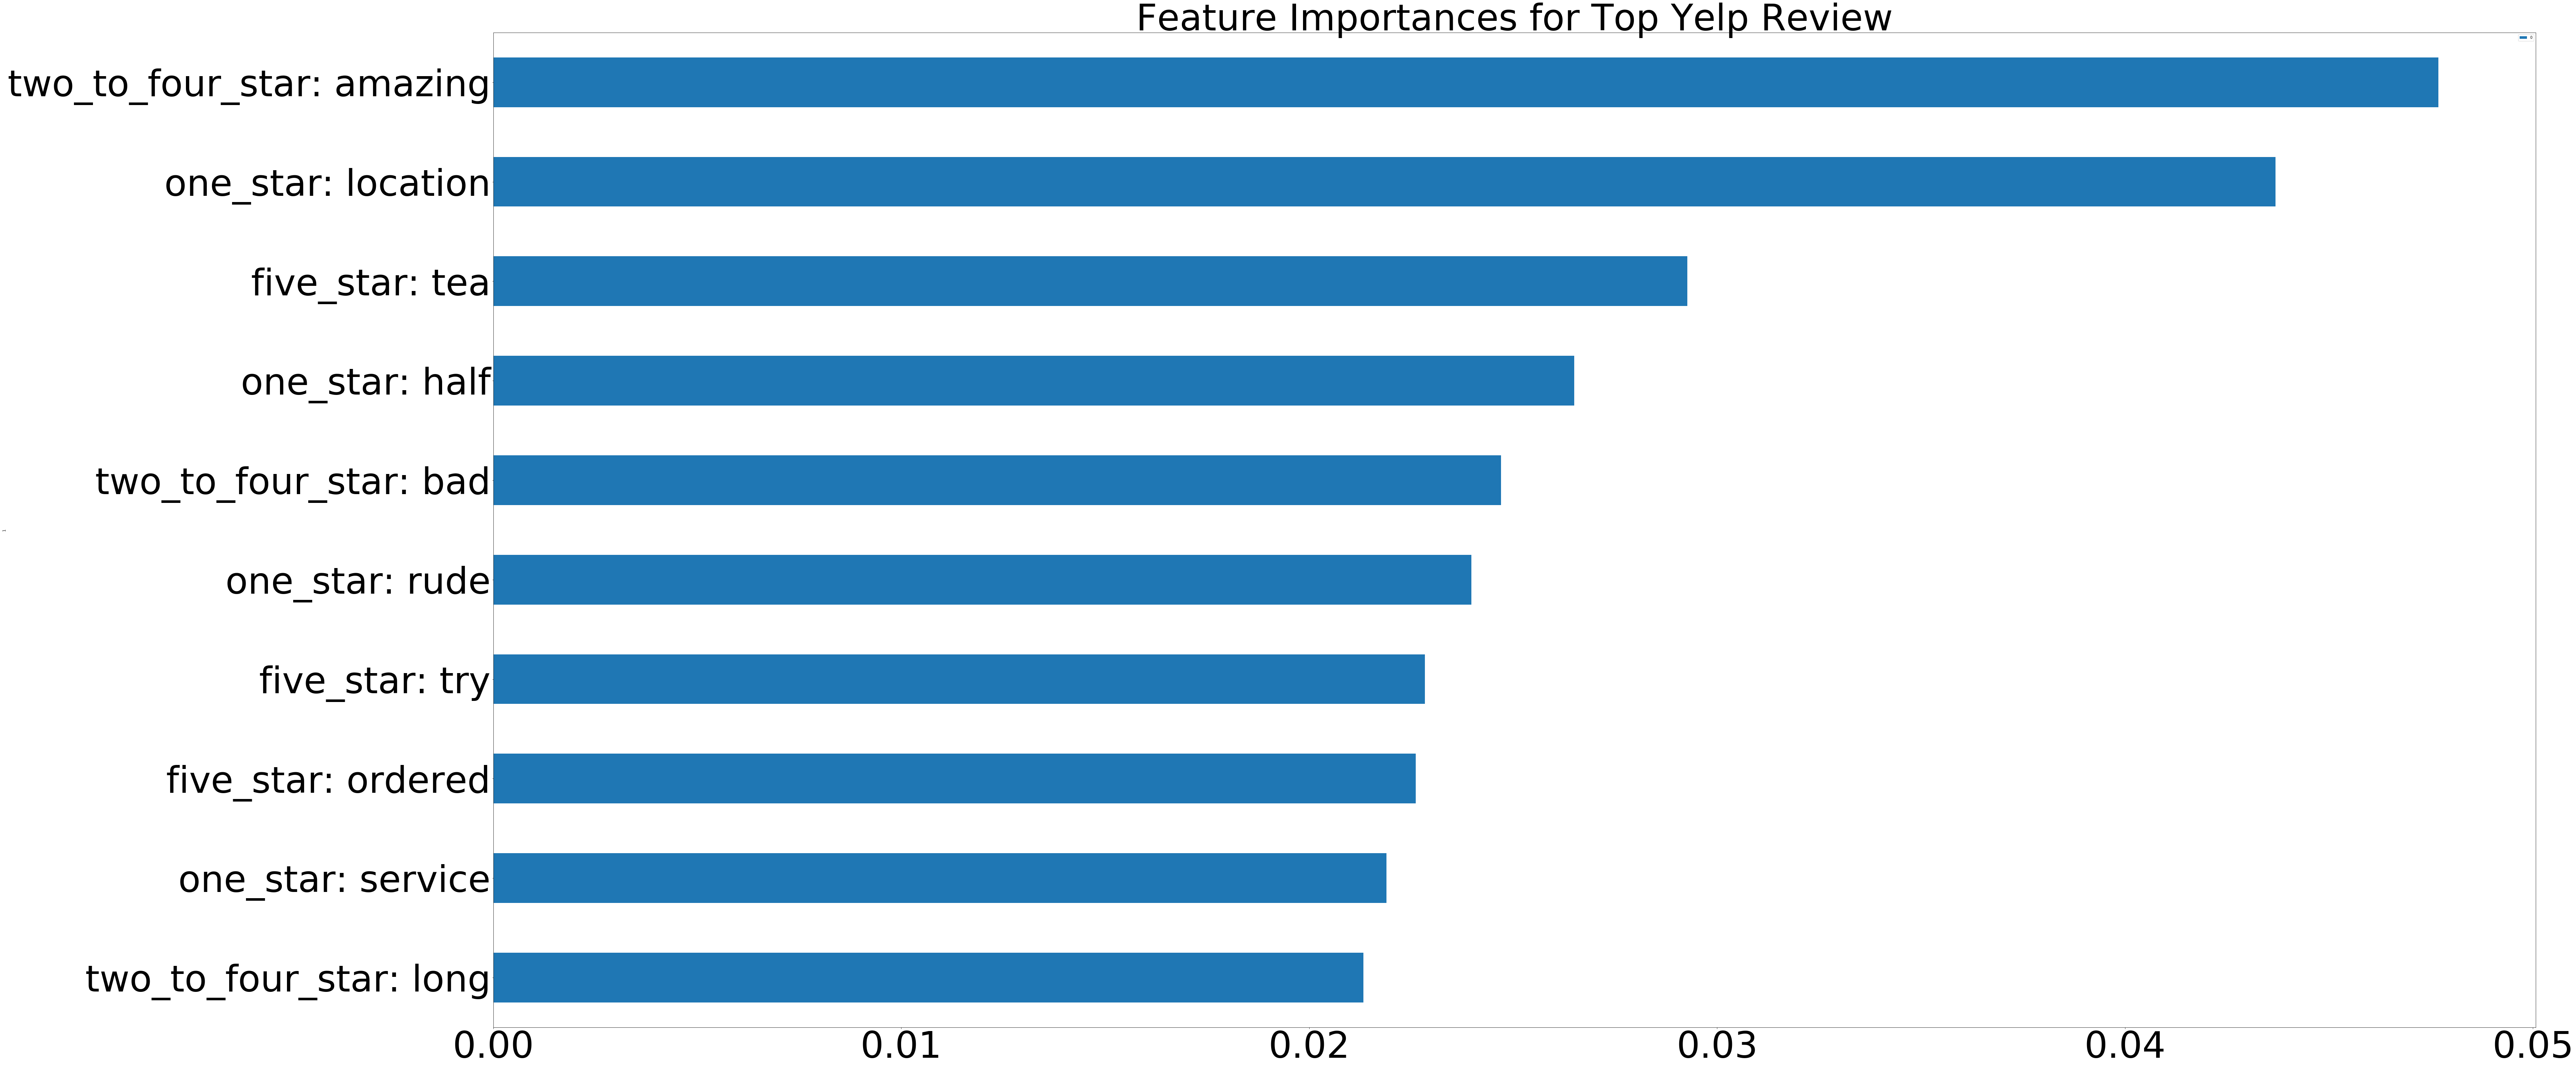

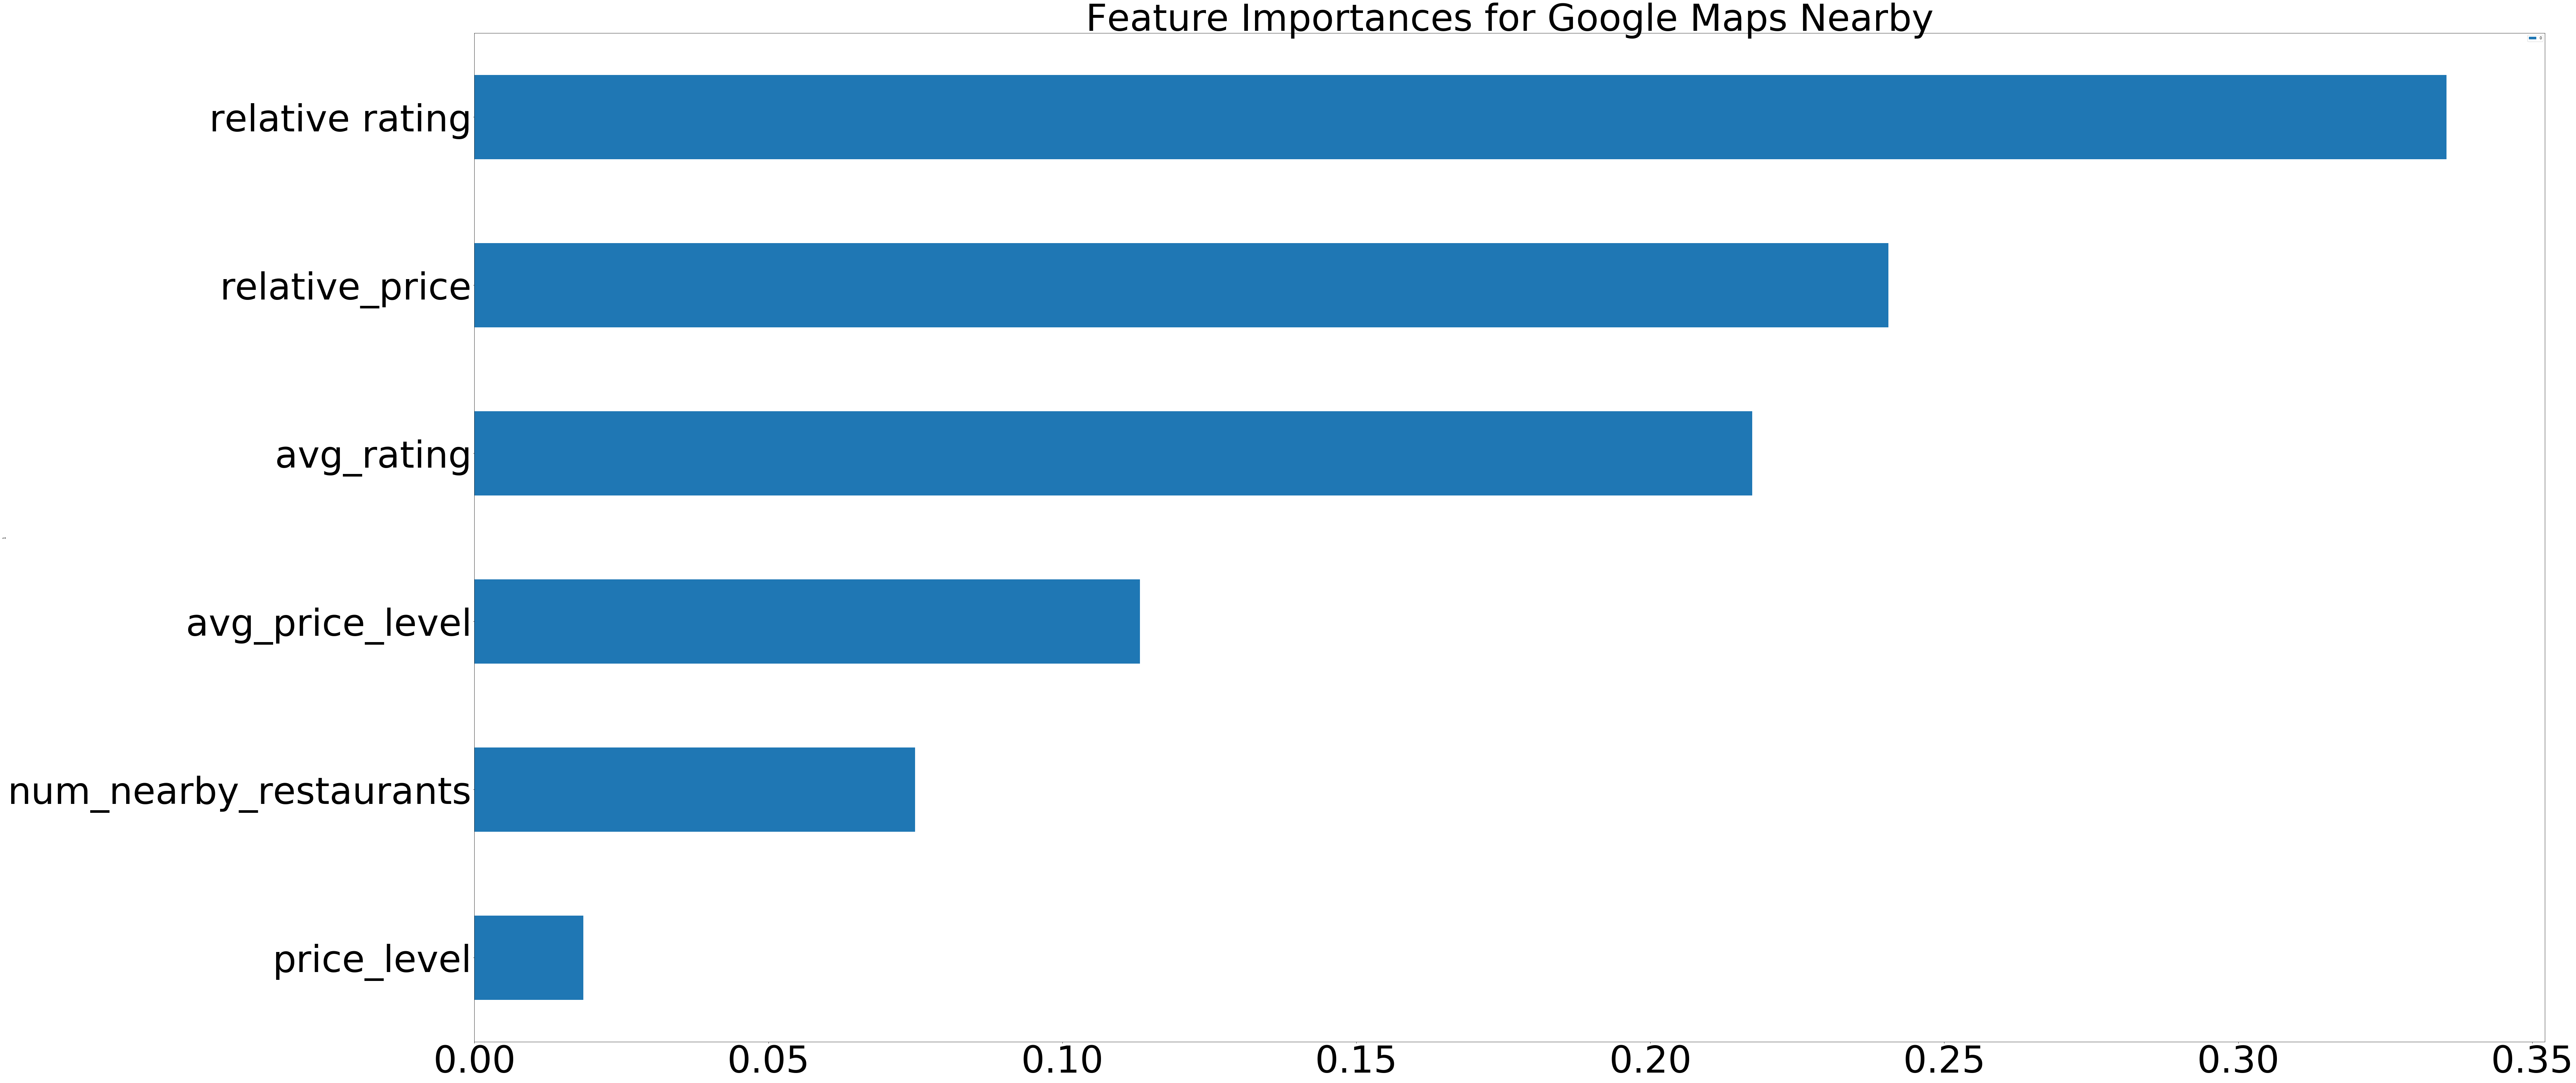

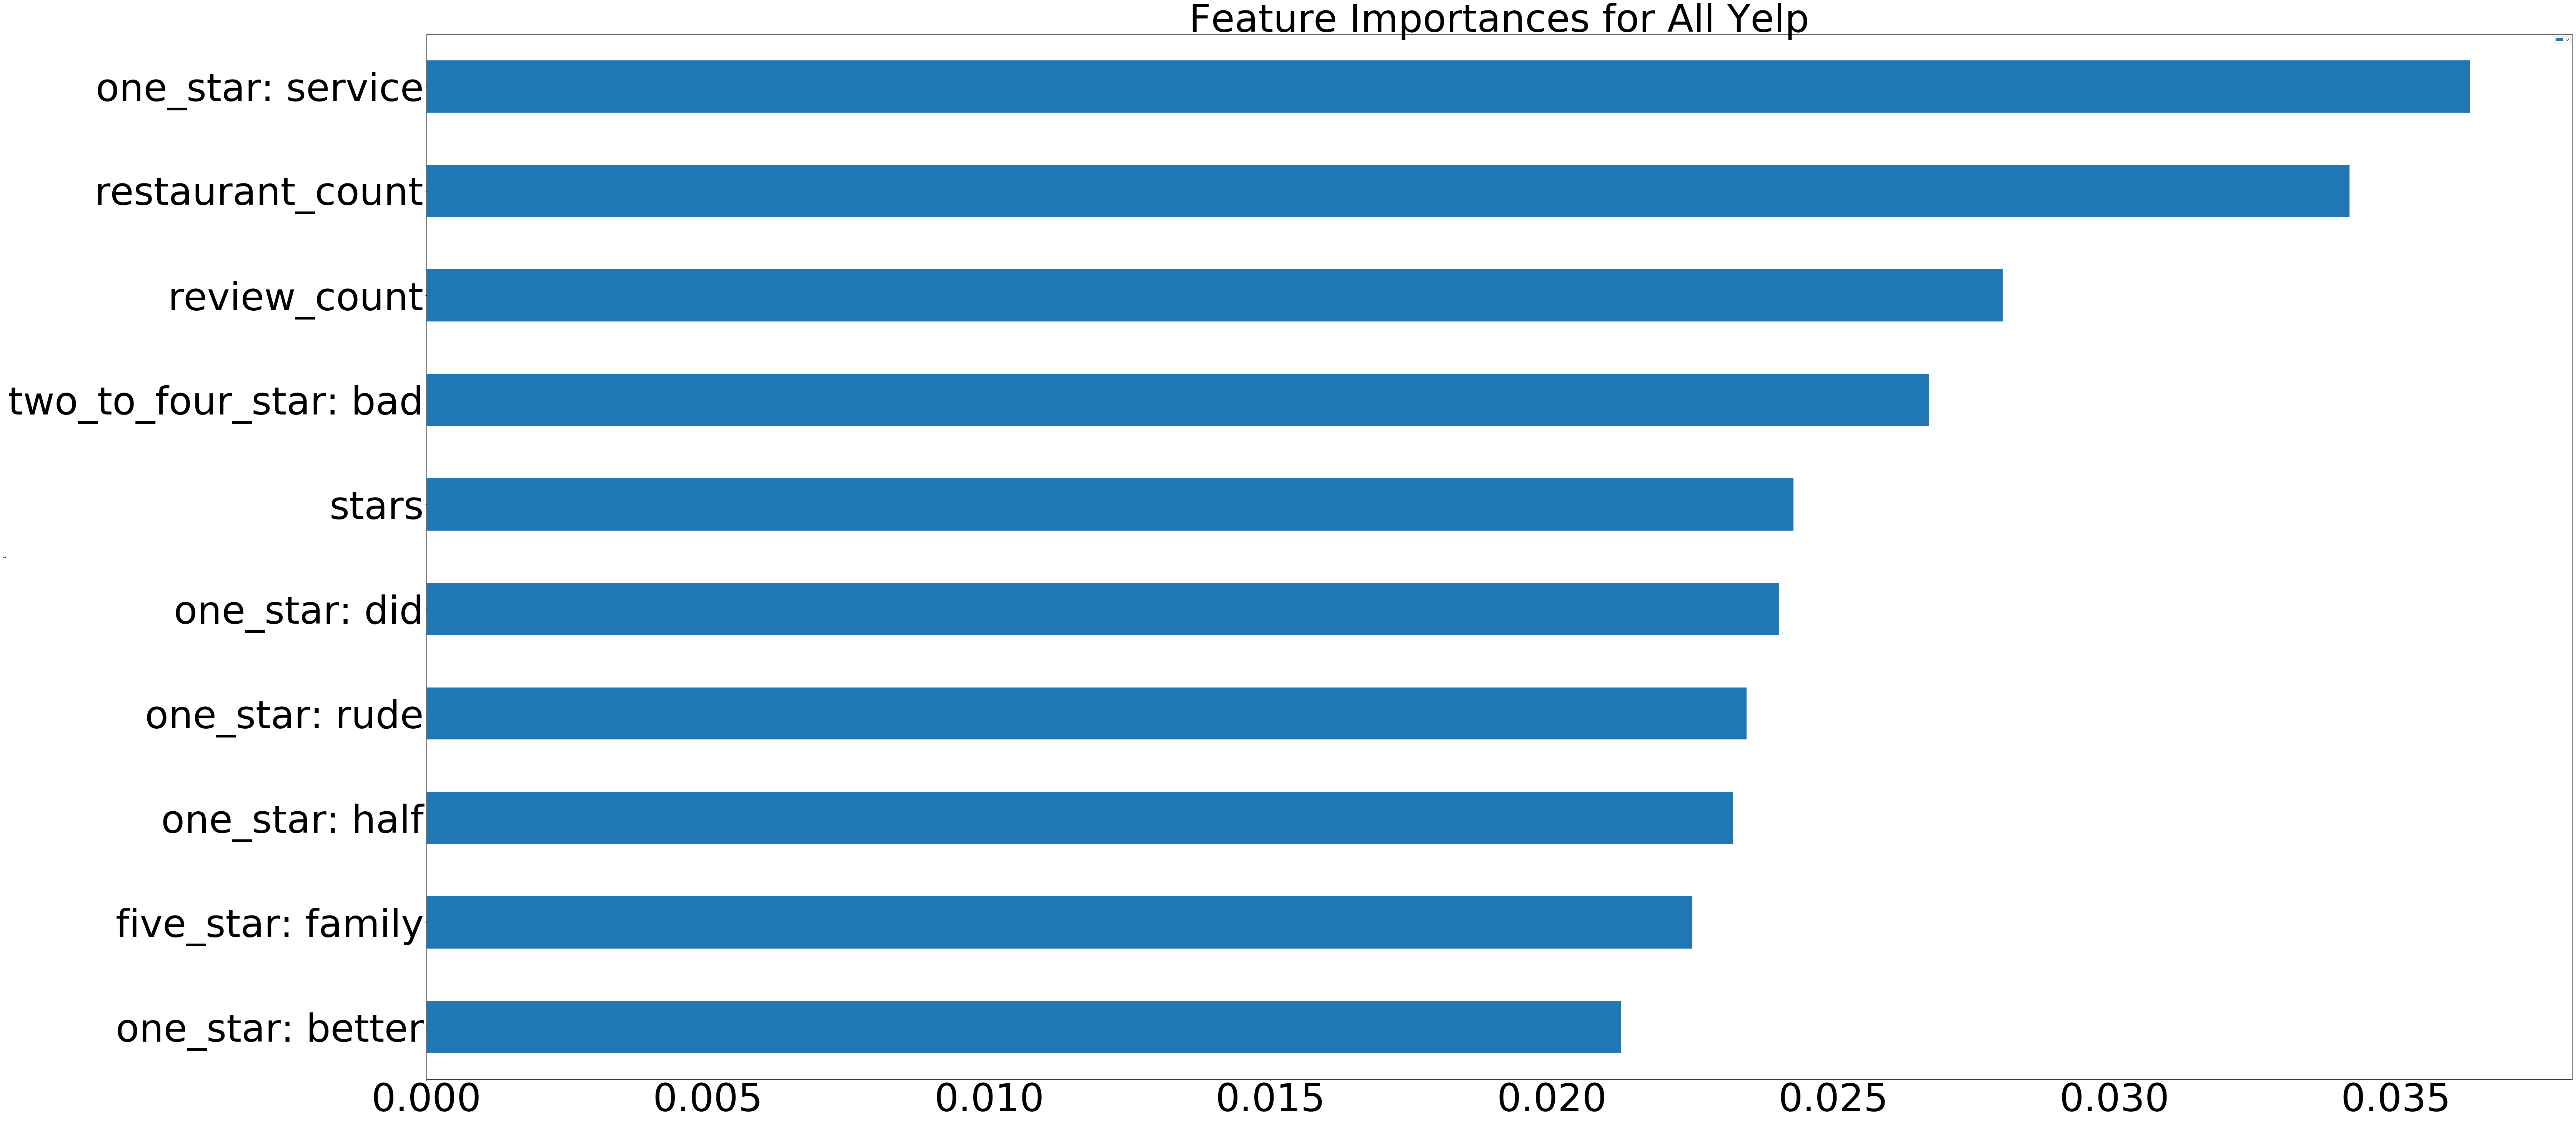

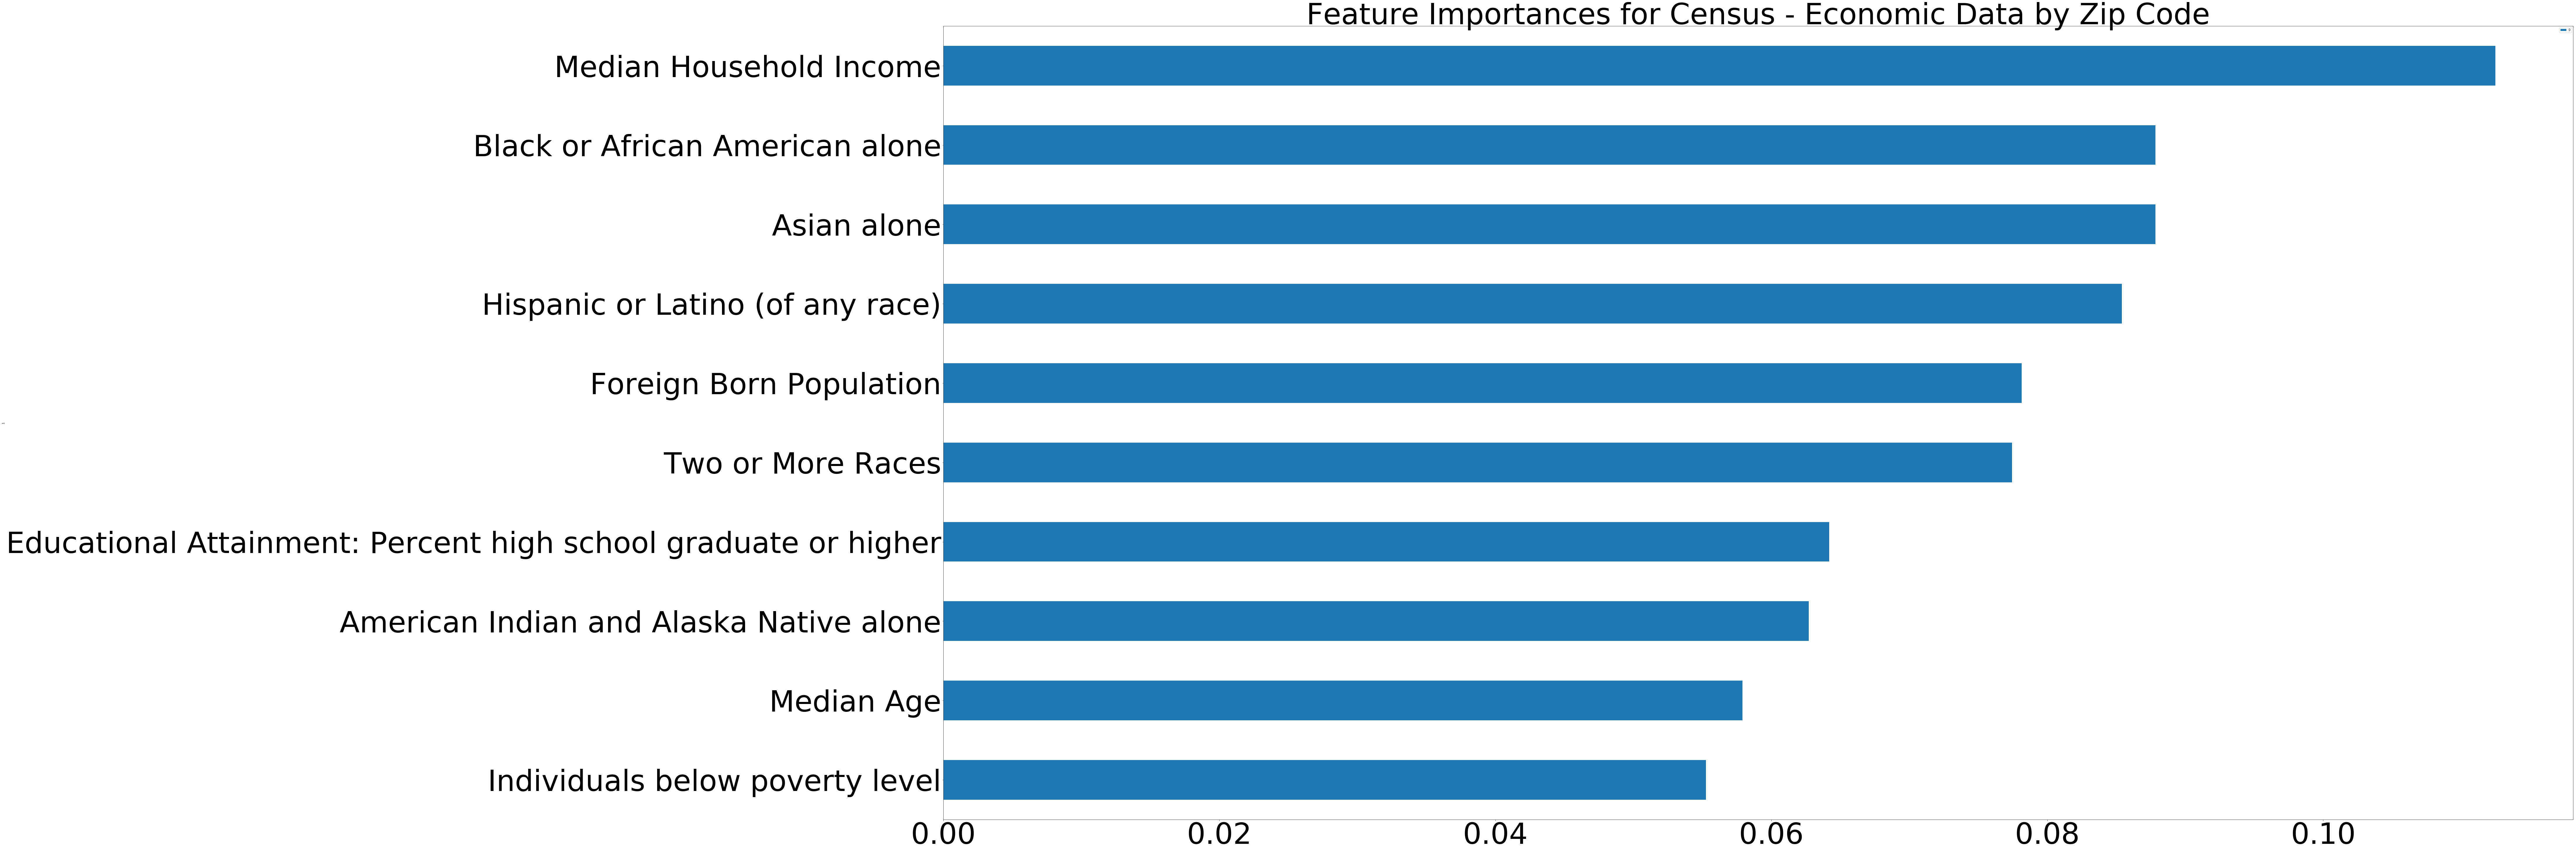

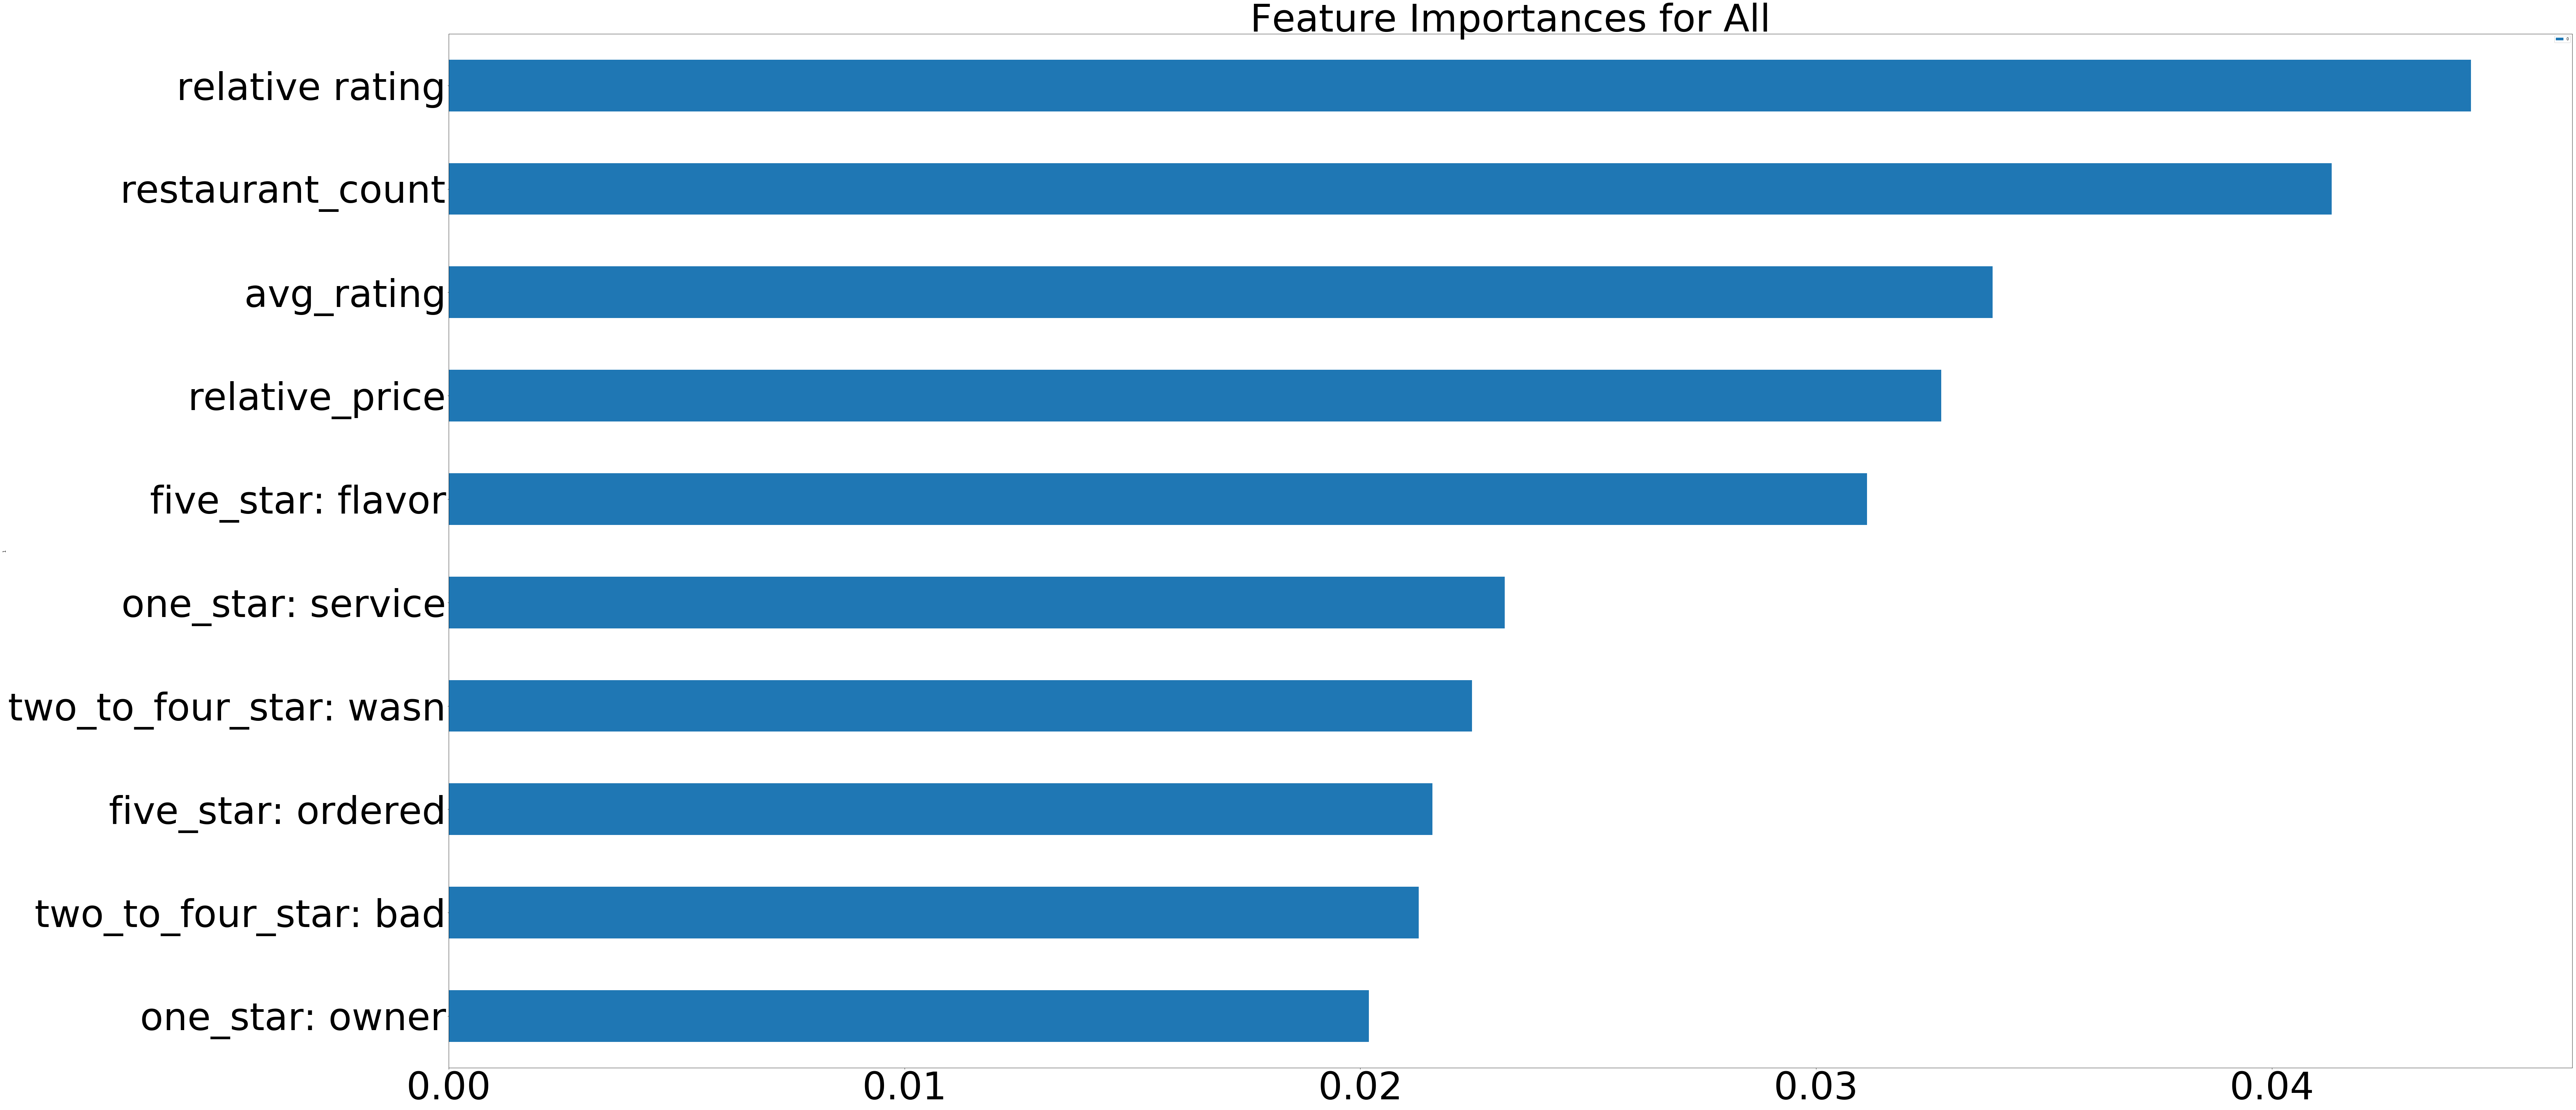

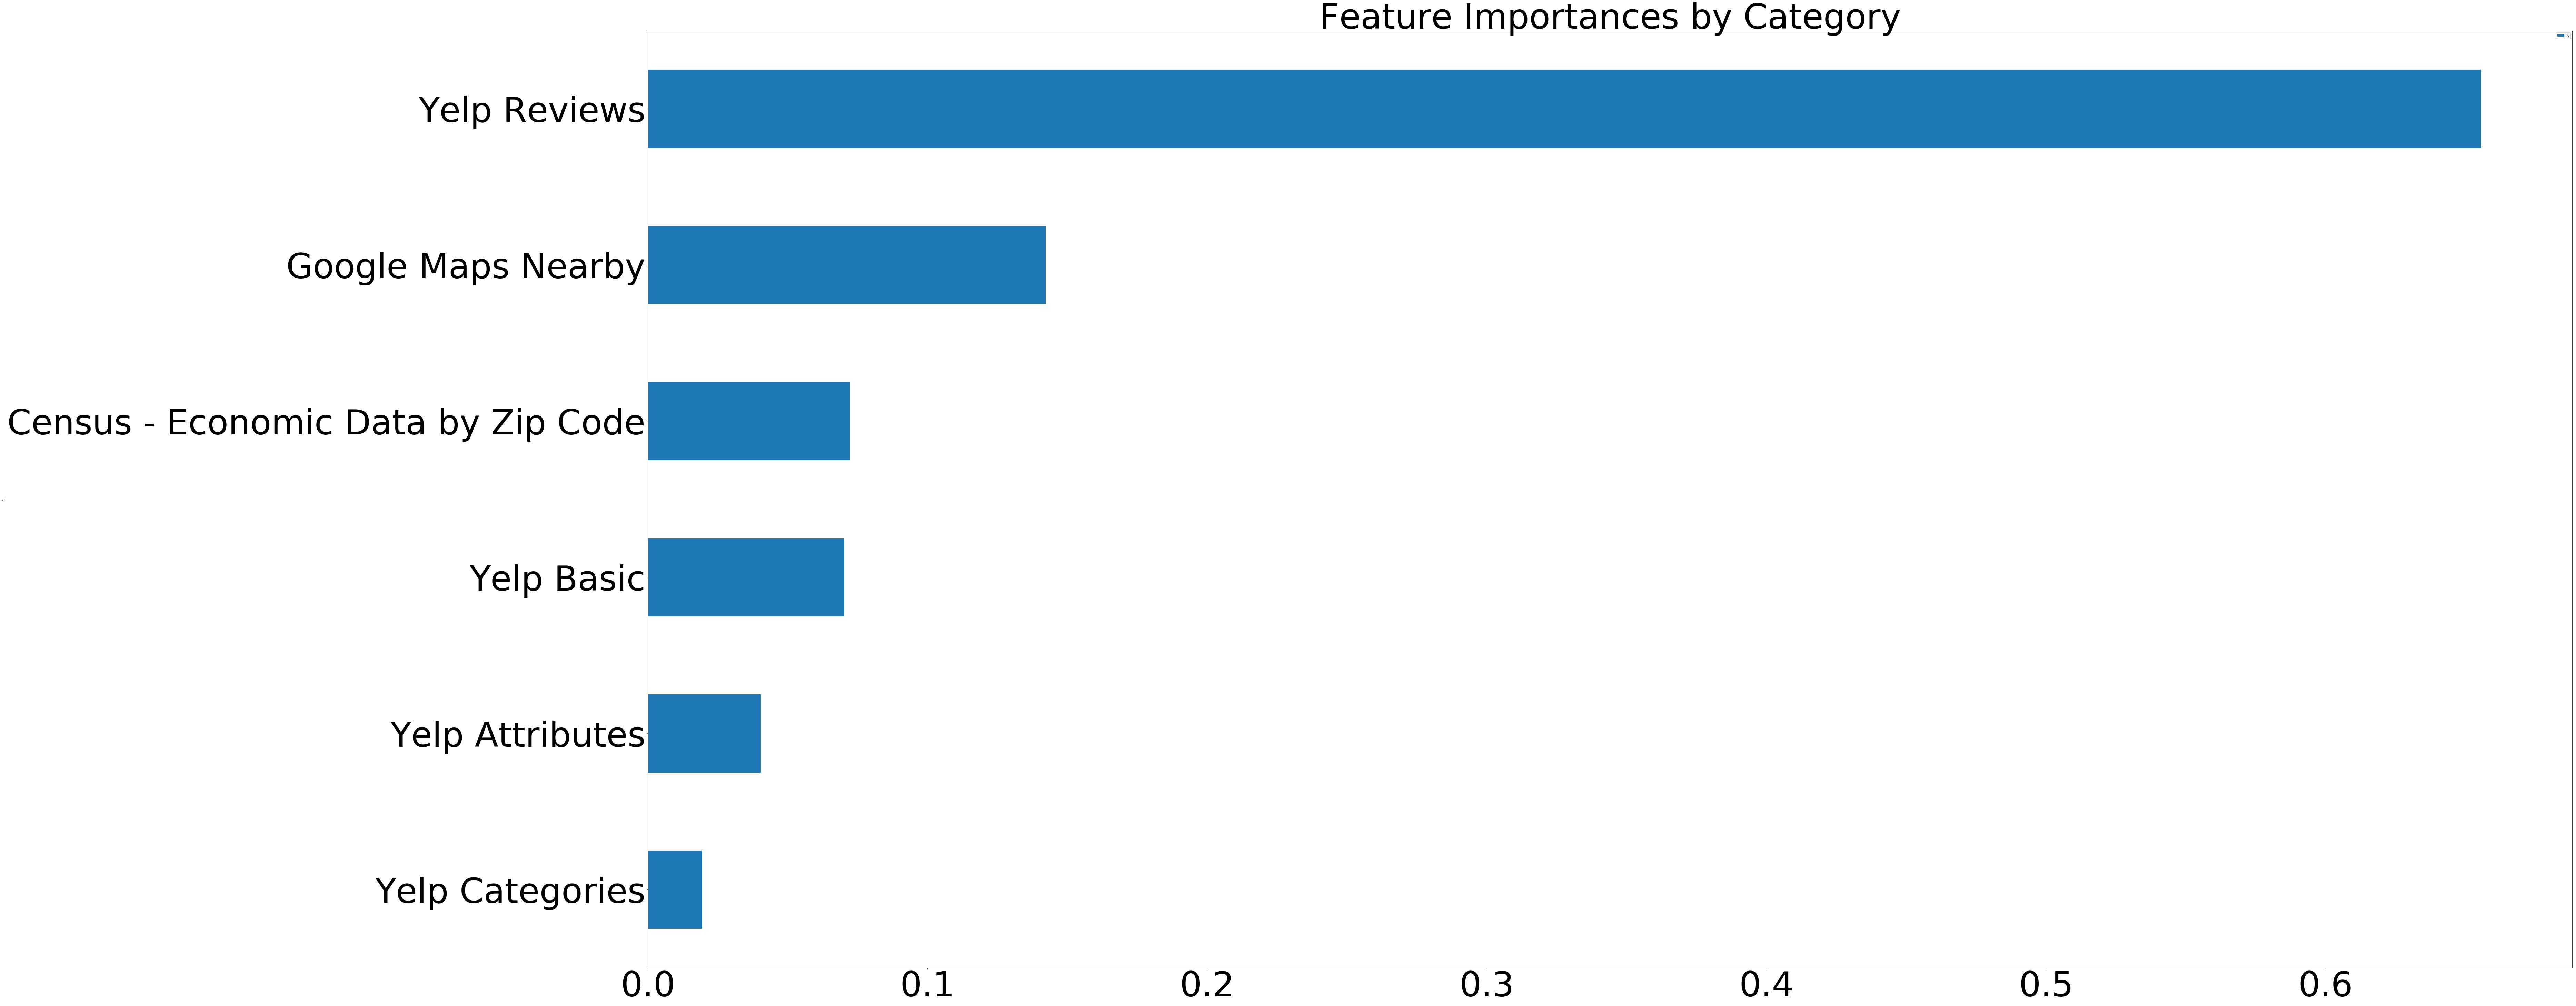

In [200]:
try:
    df = pd.read_json('../data/featurized_dataframe.json')
    print("Dataframe read from local .json")
except ValueError:
    print("Dataframe json being read from s3. Consider running \'featurize.py\' first if you'll be running this\
            multiple times.")
    df = pd.read_json('https://s3-us-west-2.amazonaws.com/businesspredictiondata/featurized_dataframe.json')

yelp_basic = ['restaurant_count','restaurant_count > 1','restaurant_count > 5',
                'restaurant_count > 25','review_count','stars']

yelp_categories = [col for col in df.columns if col.startswith('Category')]

yelp_attributes = [col for col in df.columns if col.startswith('Attribute')]

yelp_review_prefixes = ('one_star','two_to_four_star','five_star')
yelp_review_features = [col for col in df.columns if col.startswith(yelp_review_prefixes)]
top_yelp_review_features = rf_best_features(df, yelp_review_features, 100)[1]

all_yelp_columns = yelp_basic + yelp_attributes + yelp_categories + top_yelp_review_features

google_maps_nearby_columns = ['avg_price_level','avg_rating','num_nearby_restaurants','relative rating',
                            'price_level','relative_price']

census_columns = ['2016 ACS 5-Year Population Estimate',
                 'American Indian and Alaska Native alone',
                 'Asian alone',
                 'Black or African American alone',
                 'Census 2010 Total Population',
                 'Educational Attainment: Percent high school graduate or higher',
                 'Foreign Born Population',
                 'Hispanic or Latino (of any race)',
                 'Individuals below poverty level',
                 'Median Age',
                 'Median Household Income',
                 'Native Hawaiian and Other Pacific Islander alone',
                 'Some Other Race alone',
                 'Total housing units',
                 'Two or More Races',
                 'Veterans',
                 'White alone']

info_columns = ['name','city','state','postal_code','address','business_id','latitude','longitude','neighborhood']

all_columns = all_yelp_columns + google_maps_nearby_columns + census_columns

print("Column groups created")

x_column_sets = {'Yelp Basic':yelp_basic, 'Yelp Categories':yelp_categories,
                'Yelp Attributes':yelp_attributes,'Top Yelp Review':top_yelp_review_features,
                'Google Maps Nearby':google_maps_nearby_columns,'All Yelp':all_yelp_columns,
                'Census - Economic Data by Zip Code':census_columns, 'All': all_columns}

x_df = df[x_column_sets['All']]

y_df = df[['closed_on_google']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.33, random_state=10)

print("Fitting, testing, and creating/saving figs for 4 classifiers...")
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
plot_roc(rf_model, X_test, y_test)
best_values, best_features = get_best_features(rf_model, X_test.columns, 10)
plot_best_features(best_values, best_features, "Best Features for Random Forest",
                   10, 100, 50)

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
plot_roc(gb_model, X_test, y_test)
best_values, best_features = get_best_features(gb_model, X_test.columns, 10)
plot_best_features(best_values, best_features, "Best Features for Gradient Boost",
                   10, 100, 50)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
plot_roc(dt_model, X_test, y_test)
best_values, best_features = get_best_features(dt_model, X_test.columns, 10)
plot_best_features(best_values, best_features, "Best Features for Decision Tree",
                   10, 100, 50)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)
plot_roc(ab_model, X_test, y_test)
best_values, best_features = get_best_features(ab_model, X_test.columns, 10)
plot_best_features(best_values, best_features, "Best Features for Ada Boost",
                   10, 100, 50)

print("Plotting best features within each column group...")
for key, columns in x_column_sets.items():
    gb_model = GradientBoostingClassifier(n_estimators=100)
    gb_model.fit(X_train[columns], y_train)
    plot_roc(gb_model, X_test[columns], y_test, title=key + " Columns")
    best_values, best_features = get_best_features(gb_model, X_test[columns].columns, 10)
    plot_best_features(best_values, best_features, f"Feature Importances for {key}",
                       10, 100, 50)

all_values, all_features = get_best_features(gb_model, all_columns, len(all_columns))

feature_dict = {'Yelp Basic':x_column_sets['Yelp Basic'], 'Yelp Categories':x_column_sets['Yelp Categories'], \
                'Yelp Attributes':x_column_sets['Yelp Attributes'],
                'Yelp Reviews':x_column_sets['Top Yelp Review'],
                 'Google Maps Nearby':x_column_sets['Google Maps Nearby'],
               'Census - Economic Data by Zip Code':x_column_sets['Census - Economic Data by Zip Code']}
feature_category_values = {'Yelp Basic':0, 'Yelp Categories':0, \
                'Yelp Attributes':0,'Yelp Reviews':0,
                 'Google Maps Nearby':0,
               'Census - Economic Data by Zip Code':0}

feature_value_pairs = dict(list(zip(all_features, all_values)))

for key, values in feature_dict.items():
    for v in values:
        feature_category_values[key] += feature_value_pairs[v]

plot_best_features(list(feature_category_values.values()),list(feature_category_values.keys()), 
                   "Feature Importances by Category", 10, 100, 50)